#### KÜTÜPHANE TANIMLAMALARI

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import LocalOutlierFactor
import missingno as msno
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler

#### TERMİNAL DÜZENLEMELERİ

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_row', None)
pd.set_option('display.width', 500)
pd.set_option('display.float_format', lambda x: '%.3f' % x) #virgülden sonra üç basamak göster

### DATASET İNCELEMESİ

In [3]:
df = pd.read_csv('walmart.csv')
df.head()

Store  Dept        Date  Weekly_Sales  IsHoliday  Temperature  Fuel_Price  MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5     CPI  Unemployment Type    Size  Day  Month  Year
0      1     1  2010-02-05     24924.500      False       42.310       2.572        NaN        NaN        NaN        NaN        NaN 211.096         8.106    A  151315    5      2  2010
1      1     1  2010-02-12     46039.490       True       38.510       2.548        NaN        NaN        NaN        NaN        NaN 211.242         8.106    A  151315   12      2  2010
2      1     1  2010-02-19     41595.550      False       39.930       2.514        NaN        NaN        NaN        NaN        NaN 211.289         8.106    A  151315   19      2  2010
3      1     1  2010-02-26     19403.540      False       46.630       2.561        NaN        NaN        NaN        NaN        NaN 211.320         8.106    A  151315   26      2  2010
4      1     1  2010-03-05     21827.900      False       46.500       2.625        NaN        NaN        NaN        NaN        NaN 211.350         8.106    A  151315    5      3  2010

In [4]:
# date kolonunu datetime formatına çevirelim
# date kolonunu index olarak ayarlayalım 
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.head()

Store  Dept  Weekly_Sales  IsHoliday  Temperature  Fuel_Price  MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5     CPI  Unemployment Type    Size  Day  Month  Year
Date                                                                                                                                                                                 
2010-02-05      1     1     24924.500      False       42.310       2.572        NaN        NaN        NaN        NaN        NaN 211.096         8.106    A  151315    5      2  2010
2010-02-12      1     1     46039.490       True       38.510       2.548        NaN        NaN        NaN        NaN        NaN 211.242         8.106    A  151315   12      2  2010
2010-02-19      1     1     41595.550      False       39.930       2.514        NaN        NaN        NaN        NaN        NaN 211.289         8.106    A  151315   19      2  2010
2010-02-26      1     1     19403.540      False       46.630       2.561        NaN        NaN        NaN        NaN        NaN 211.320         8.106    A  151315   26      2  2010
2010-03-05      1     1     21827.900      False       46.500       2.625        NaN        NaN        NaN        NaN        NaN 211.350         8.106    A  151315    5      3  2010

In [5]:
#veri inceleme fonksiyonumuz
def check_df(dataframe,head=5):
    print("############### SHAPE ######################")
    print(dataframe.shape)
    print("############### INDEX ######################")
    print(dataframe.index)
    print("############### TYPES ######################")
    print(dataframe.dtypes)
    print("############### HEAD ######################")
    print(dataframe.head(head))
    print("############### TAIL ######################")
    print(dataframe.tail(head))
    print("############### NULL ######################")
    print(dataframe.isnull().sum())
    print("############### QUANTILES ######################")
    print(dataframe.describe([0.05, 0.5, 0.25, 0.95, 0.99,]).T)

In [6]:
check_df(df)

############### SHAPE ######################
(421570, 18)
############### INDEX ######################
DatetimeIndex(['2010-02-05', '2010-02-12', '2010-02-19', '2010-02-26', '2010-03-05', '2010-03-12', '2010-03-19', '2010-03-26', '2010-04-02', '2010-04-09',
               ...
               '2012-08-24', '2012-08-31', '2012-09-07', '2012-09-14', '2012-09-21', '2012-09-28', '2012-10-05', '2012-10-12', '2012-10-19', '2012-10-26'], dtype='datetime64[ns]', name='Date', length=421570, freq=None)
############### TYPES ######################
Store             int64
Dept              int64
Weekly_Sales    float64
IsHoliday          bool
Temperature     float64
Fuel_Price      float64
MarkDown1       float64
MarkDown2       float64
MarkDown3       float64
MarkDown4       float64
MarkDown5       float64
CPI             float64
Unemployment    float64
Type             object
Size              int64
Day               int64
Month             int64
Year              int64
dtype: object
#############

#### BAZI DEĞİŞKENLERİ İLİŞKİLENDİRELİM

Type ve Size arasındaki ilişkiye bakalım. Mağaza türüne göre size kontrol edelim.

In [7]:
stdf = df.groupby('Type').agg(
    min_size=('Size', 'min'),
    avg_size=('Size', 'mean'),
    max_size=('Size', 'max')
).reset_index()

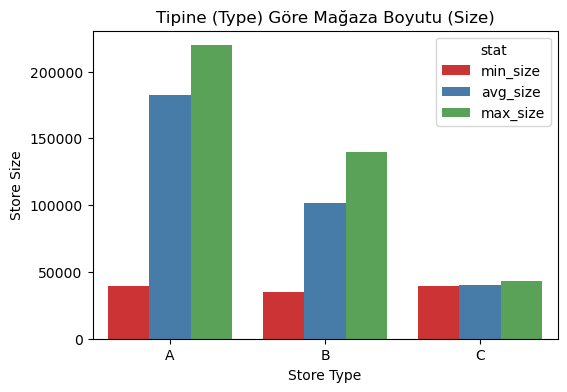

In [8]:
m_df = pd.melt(stdf, id_vars="Type", var_name="stat", value_name="Size")

fig, ax = plt.subplots(figsize=(6, 4))
sns.barplot(x='Type', y='Size', hue='stat', data=m_df, ax=ax, palette='Set1')
plt.title('Tipine (Type) Göre Mağaza Boyutu (Size)')
plt.xlabel('Store Type')
plt.ylabel('Store Size')
plt.show()

#### KATEGORİK-NUMERİK AYRIMI

In [9]:
#önce cat_th ve car_Th belirlemek için kolonlarımızdaki unique değer sayısına bakalım.
for col in df.columns:
    print(col, df[col].nunique())

Store 45
Dept 81
Weekly_Sales 359464
IsHoliday 2
Temperature 3528
Fuel_Price 892
MarkDown1 2277
MarkDown2 1499
MarkDown3 1662
MarkDown4 1944
MarkDown5 2293
CPI 2145
Unemployment 349
Type 3
Size 40
Day 31
Month 12
Year 3


* büyük bir veri seti olduğu için thresholdlar biraz yüksek olacak.
* manuel incelediğimde mantıken store(45), dept(81), type(3), Isholiday(2) kategorik görünüyor. Day, month, year zaten kategorik
* değişkenlerin neyi ifade ettiğini bildiğimiz için diğerlerinin sayısal olduğunu da tahmin edebiliyoruz.
* size-> mağazanın büyüklüğü. sayısal bir veri fakat unique değer sayısı düşük.
* çünkü zaten mağaza sayısı 45 iken 40 değer olması normal.
* size değişkenini threshold altında kalsa da numerik olarak alalım biz.

In [10]:
#değişkenleri kategorilerine ayırmak için fonksiyonumuz
def grab_col_names(dataframe, cat_th=90, car_th=100):
  """
  VERİ SETİNDE KATEGORİK, NUMERİK, KARDİNAL DEĞİŞKENLERİ DÖNDÜRECEK FONKSİYON

  Parameters
  ----------
  dataframe: dataframe
        değişken isimleri alınmak istenen dataframedir
  cat_th: int,float
        numerik fakat kategorik olan değişkenler için sınıf eşik değeri
  car_th: int, float
        kategorik fakat kardinal değişkenler için sınıf eşik değeri

  Returns
  -------
  cat_cols: list
        kategorik değişken listesi
  num_cols: list
        numerik değişken listesi
  cat_but_car: list
        kategorik görünümlü kardinal değişken listesi

  Notes
  -------
  cat_cols + num_cols + cat_but_car = toplam değişken sayısı
  num_but_cat, cat_cols'un içerisinde

  """
  # kategorik değişkenler
  cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes in ["category", "object", "bool"]]
  # sayısal gibi görünen kategorik değişkenler
  num_but_cat = [col for col in dataframe.columns if
                 dataframe[col].nunique() < cat_th and dataframe[col].dtypes in ["int32", "float32", "int64", "float64"]]
  # kardinal değişkenler
  cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and str(dataframe[col].dtypes) in ["category", "object"]]
  cat_cols = cat_cols + num_but_cat  # num but cat olanlar kategorik sayılacağı için ekledik
  cat_cols = [col for col in cat_cols if
              col not in cat_but_car]  # son olarak varsa kardinal değişkenleri cat collar içinden çıkarıyoruz

  num_cols = [col for col in dataframe.columns if dataframe[col].dtypes in ["int64", "float64", "int32", "float32"]]
  num_cols = [col for col in num_cols if col not in cat_cols]

  print("Observation: ", dataframe.shape[0])
  print("Variables: ", dataframe.shape[1])
  print("cat_cols: ", len(cat_cols))
  print("num_cols: ", len(num_cols))
  print("cat_but_car: ", len(cat_but_car))
  print("num_but_cat: ", len(num_but_cat))

  return cat_cols, num_cols, cat_but_car

In [11]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observation:  421570
Variables:  18
cat_cols:  8
num_cols:  10
cat_but_car:  0
num_but_cat:  6


In [12]:
cat_cols

['IsHoliday', 'Type', 'Store', 'Dept', 'Size', 'Day', 'Month', 'Year']

In [13]:
num_cols

['Weekly_Sales',
 'Temperature',
 'Fuel_Price',
 'MarkDown1',
 'MarkDown2',
 'MarkDown3',
 'MarkDown4',
 'MarkDown5',
 'CPI',
 'Unemployment']

In [14]:
cat_but_car

[]

In [15]:
# size değişkenini numerik kolonlara ekleyip kategorikten silelim
num_cols.append("Size")
cat_cols.remove("Size")

#### KATEGORİK DEĞİŞKENLERİ İNCELEME VE GÖRSELLEŞTİRME

In [16]:
# öncelikle görselleştirebilmek için kategorik bool değişkene bir dönüşüm uygulayalım
for col in df.columns:
    if df[col].dtypes == "bool":
        df[col] = df[col].astype(int)

In [17]:
# kategorik değişkenlerin farklı değerlerinin dataframedeki dağılımına bakalım
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("********************************************")
    if plot:
        sns.countplot(x= dataframe[col_name], data= dataframe)
        plt.show(block=True)

           IsHoliday  Ratio
IsHoliday                  
0             391909 92.964
1              29661  7.036
********************************************


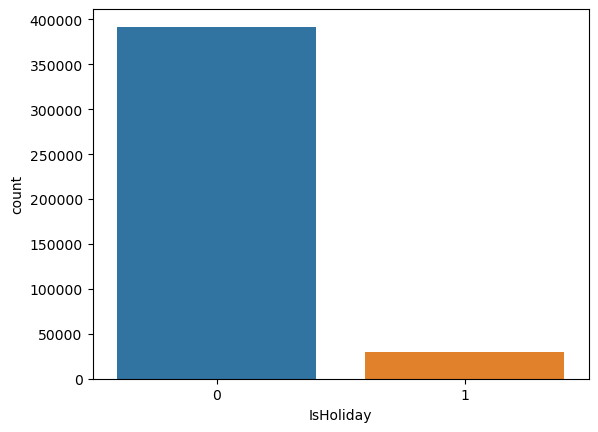

        Type  Ratio
Type               
A     215478 51.113
B     163495 38.782
C      42597 10.104
********************************************


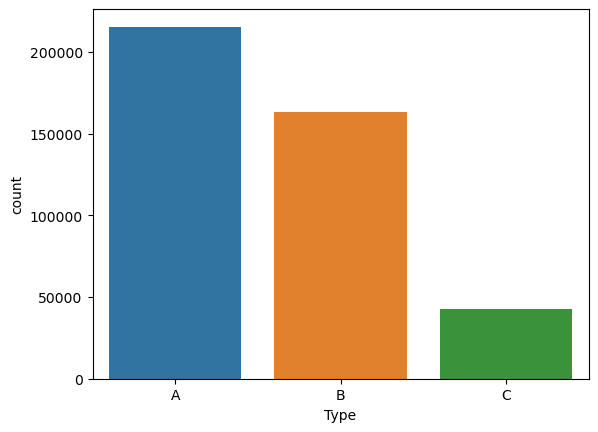

       Store  Ratio
Store              
13     10474  2.485
10     10315  2.447
4      10272  2.437
1      10244  2.430
2      10238  2.429
24     10228  2.426
27     10225  2.425
34     10224  2.425
20     10214  2.423
6      10211  2.422
32     10202  2.420
19     10148  2.407
31     10142  2.406
28     10113  2.399
41     10088  2.393
11     10062  2.387
23     10050  2.384
14     10040  2.382
40     10017  2.376
15      9901  2.349
8       9895  2.347
39      9878  2.343
17      9864  2.340
18      9859  2.339
26      9854  2.337
25      9804  2.326
7       9762  2.316
12      9705  2.302
22      9688  2.298
45      9637  2.286
21      9582  2.273
35      9528  2.260
29      9455  2.243
16      9443  2.240
3       9036  2.143
5       8999  2.135
9       8867  2.103
38      7362  1.746
37      7206  1.709
44      7169  1.701
30      7156  1.697
42      6953  1.649
43      6751  1.601
33      6487  1.539
36      6222  1.476
********************************************


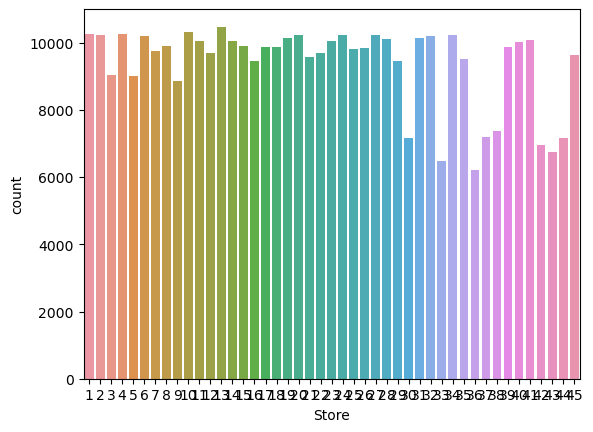

      Dept  Ratio
Dept             
1     6435  1.526
16    6435  1.526
92    6435  1.526
38    6435  1.526
40    6435  1.526
2     6435  1.526
82    6435  1.526
46    6435  1.526
95    6435  1.526
81    6435  1.526
79    6435  1.526
21    6435  1.526
90    6435  1.526
91    6435  1.526
14    6435  1.526
4     6435  1.526
13    6435  1.526
3     6435  1.526
10    6435  1.526
8     6435  1.526
7     6435  1.526
67    6435  1.526
11    6434  1.526
74    6430  1.525
17    6412  1.521
12    6409  1.520
42    6401  1.518
87    6391  1.516
25    6354  1.507
9     6354  1.507
5     6347  1.506
97    6278  1.489
52    6268  1.487
28    6124  1.453
59    6106  1.448
31    6067  1.439
85    6055  1.436
72    6046  1.434
20    6032  1.431
6     5986  1.420
32    5956  1.413
93    5913  1.403
83    5908  1.401
80    5891  1.397
56    5872  1.393
98    5836  1.384
23    5774  1.370
60    5772  1.369
26    5739  1.361
94    5685  1.349
27    5619  1.333
55    5596  1.327
22    5543  1.315
44    5471

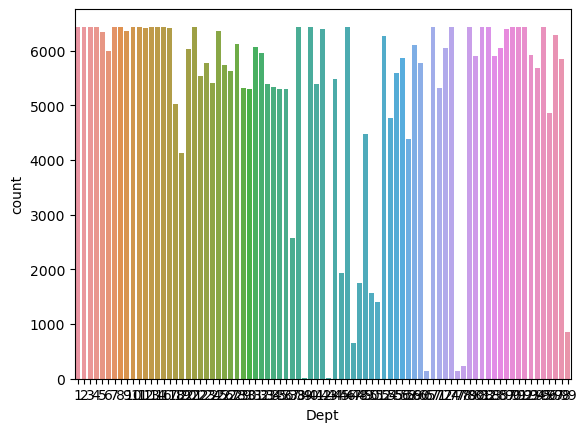

       Day  Ratio
Day              
23   14801  3.511
2    14799  3.510
6    14799  3.510
9    14796  3.510
17   14795  3.510
16   14768  3.503
10   14767  3.503
12   14760  3.501
13   14758  3.501
25   14753  3.500
30   14752  3.499
11   14749  3.499
26   14746  3.498
24   14741  3.497
3    14741  3.497
19   14739  3.496
5    14734  3.495
18   14733  3.495
20   14723  3.492
4    14703  3.488
27   14680  3.482
7    11786  2.796
22   11766  2.791
14   11763  2.790
15   11763  2.790
8    11762  2.790
1    11760  2.790
28   11752  2.788
21   11740  2.785
29   11736  2.784
31    5905  1.401
********************************************


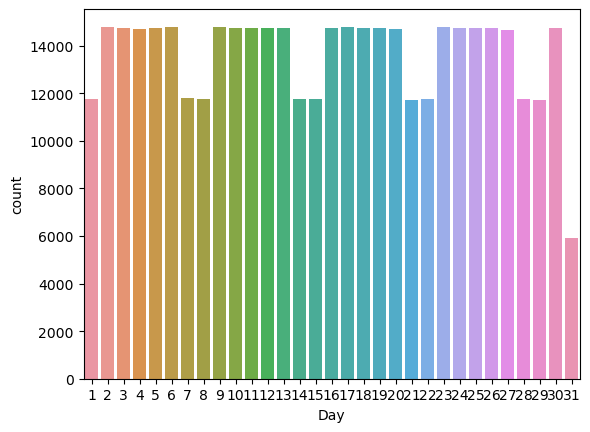

       Month  Ratio
Month              
4      41332  9.804
7      40980  9.721
3      38451  9.121
10     38362  9.100
9      38339  9.094
8      38169  9.054
6      38137  9.046
2      35526  8.427
5      35314  8.377
12     29802  7.069
11     23613  5.601
1      23545  5.585
********************************************


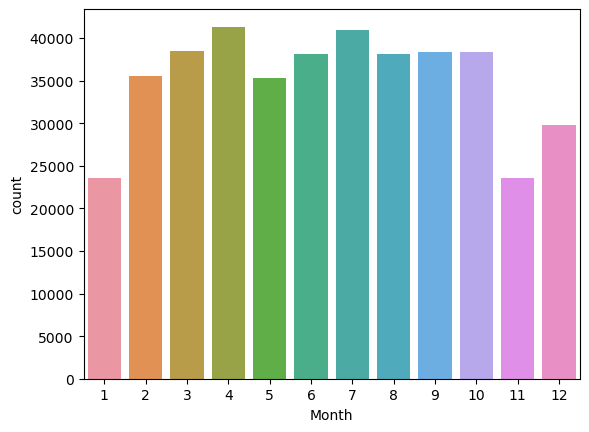

        Year  Ratio
Year               
2011  153453 36.400
2010  140679 33.370
2012  127438 30.229
********************************************


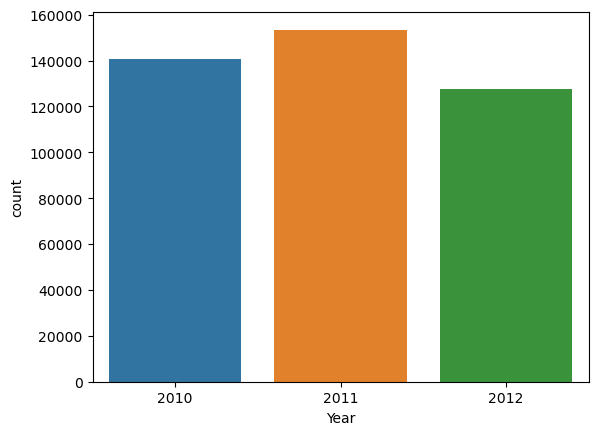

In [18]:
for col in cat_cols:
        cat_summary(df,col, plot=True)

#### NUMERİK DEĞİŞKENLERİ İNCELEME VE GÖRSELLEŞTİRME

In [19]:
# numerik değişkenlerin istatistiklerine ve histogramına bakalım
def num_summary(dataframe, numerical_col, plot=False):
    quantiles= [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist()
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)
        print("**************************************")

count   421570.000
mean     15981.258
std      22711.184
min      -4988.940
5%          59.975
10%        291.097
20%       1340.980
30%       2913.381
40%       4887.960
50%       7612.030
60%      11274.632
70%      16619.325
80%      25217.612
90%      42845.673
95%      61201.951
99%     106479.586
max     693099.360
Name: Weekly_Sales, dtype: float64


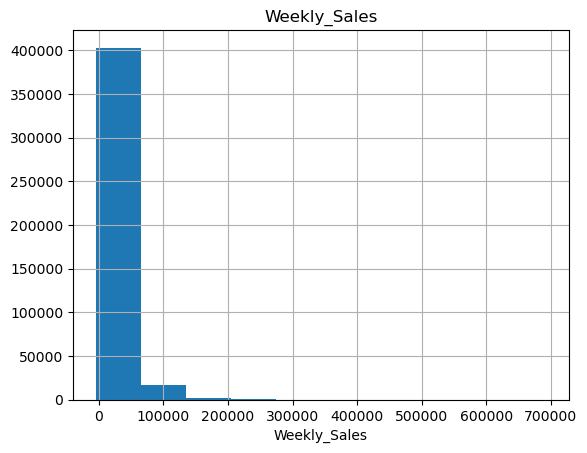

**************************************
count   421570.000
mean        60.090
std         18.448
min         -2.060
5%          27.310
10%         33.980
20%         43.330
30%         50.020
40%         56.110
50%         62.090
60%         67.410
70%         71.670
80%         77.140
90%         83.580
95%         87.270
99%         92.810
max        100.140
Name: Temperature, dtype: float64


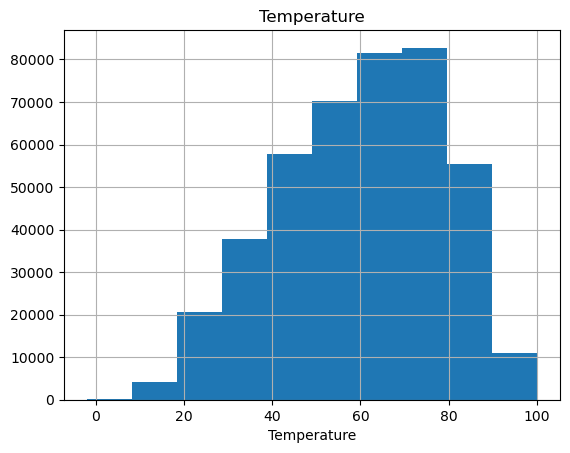

**************************************
count   421570.000
mean         3.361
std          0.459
min          2.472
5%           2.653
10%          2.720
20%          2.840
30%          3.016
40%          3.236
50%          3.452
60%          3.571
70%          3.683
80%          3.796
90%          3.917
95%          4.029
99%          4.202
max          4.468
Name: Fuel_Price, dtype: float64


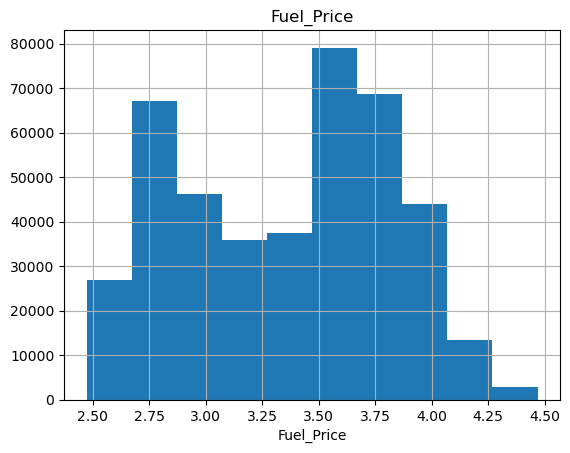

**************************************
count   150681.000
mean      7246.420
std       8291.221
min          0.270
5%         149.190
10%        375.200
20%       1524.370
30%       2799.140
40%       4034.350
50%       5347.450
60%       6623.840
70%       8325.930
80%      10526.010
90%      15282.470
95%      21801.350
99%      41524.030
max      88646.760
Name: MarkDown1, dtype: float64


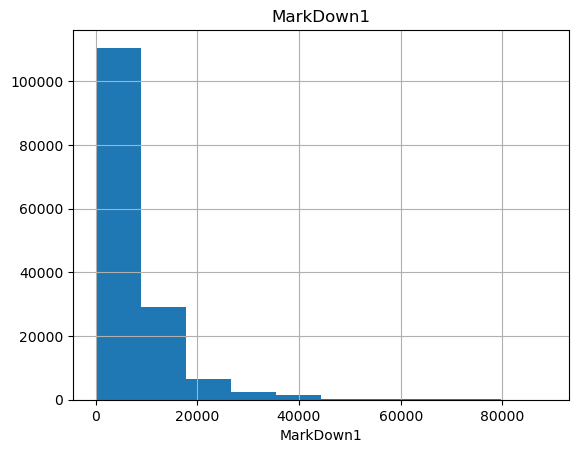

**************************************
count   111248.000
mean      3334.629
std       9475.357
min       -265.760
5%           1.950
10%          6.980
20%         25.880
30%         61.030
40%        105.350
50%        192.000
60%        364.570
70%       1050.480
80%       3368.340
90%       8549.740
95%      16497.470
99%      50366.600
max     104519.540
Name: MarkDown2, dtype: float64


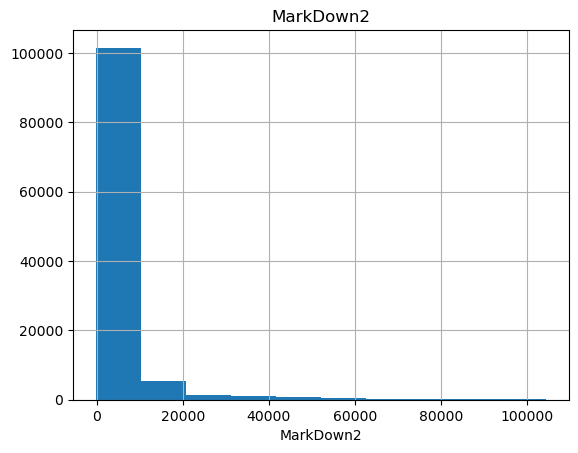

**************************************
count   137091.000
mean      1439.421
std       9623.078
min        -29.100
5%           0.650
10%          1.650
20%          3.660
30%          6.940
40%         13.060
50%         24.600
60%         43.890
70%         78.070
80%        143.420
90%        400.090
95%       1059.900
99%      63143.290
max     141630.610
Name: MarkDown3, dtype: float64


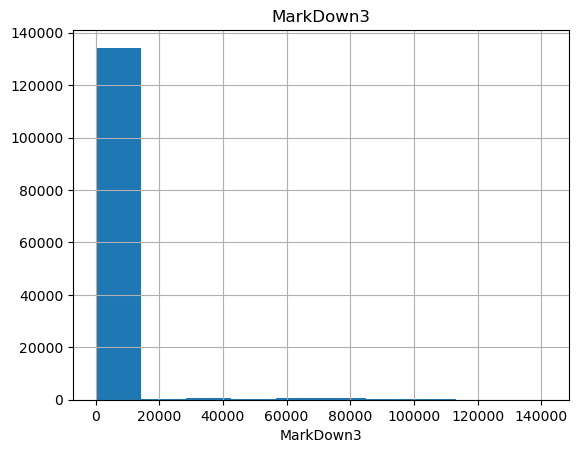

**************************************
count   134967.000
mean      3383.168
std       6292.384
min          0.220
5%          28.760
10%        108.710
20%        393.410
30%        643.780
40%       1001.420
50%       1481.310
60%       2064.370
70%       2993.150
80%       4198.540
90%       7871.420
95%      12645.960
99%      35785.260
max      67474.850
Name: MarkDown4, dtype: float64


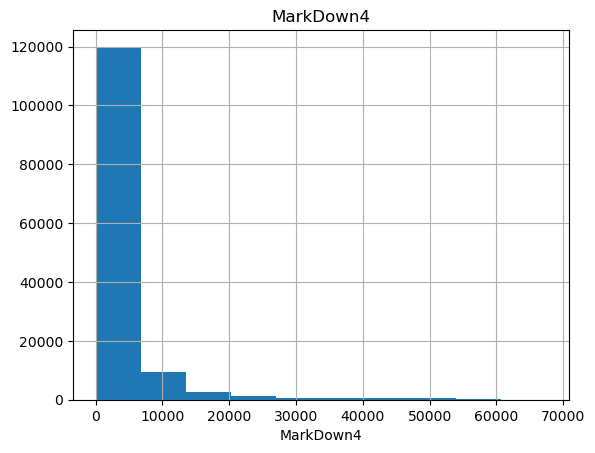

**************************************
count   151432.000
mean      4628.975
std       5962.887
min        135.160
5%         715.520
10%       1070.830
20%       1610.180
30%       2147.950
40%       2724.980
50%       3359.450
60%       4009.950
70%       4926.610
80%       6266.040
90%       8337.700
95%      11269.240
99%      27754.230
max     108519.280
Name: MarkDown5, dtype: float64


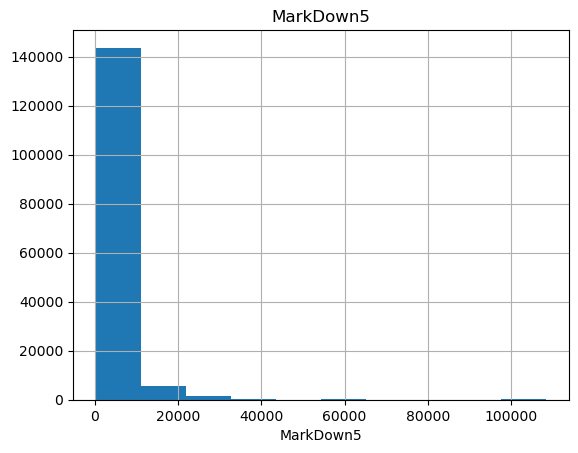

**************************************
count   421570.000
mean       171.202
std         39.159
min        126.064
5%         126.496
10%        128.824
20%        130.885
30%        132.978
40%        137.167
50%        182.319
60%        195.638
70%        210.677
80%        214.666
90%        219.444
95%        221.942
99%        225.474
max        227.233
Name: CPI, dtype: float64


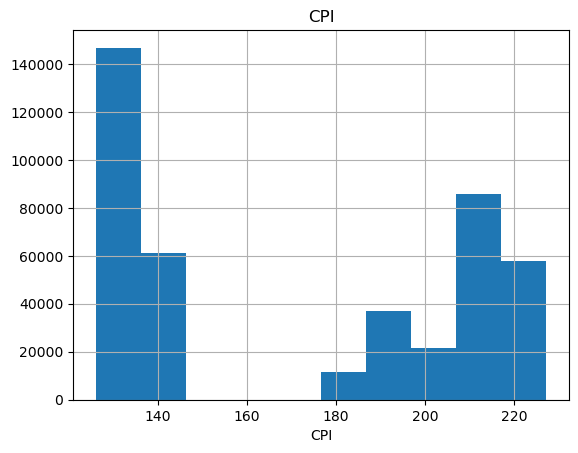

**************************************
count   421570.000
mean         7.960
std          1.863
min          3.879
5%           5.326
10%          5.965
20%          6.589
30%          7.127
40%          7.527
50%          7.866
60%          8.163
70%          8.458
80%          8.818
90%          9.816
95%         12.187
99%         14.180
max         14.313
Name: Unemployment, dtype: float64


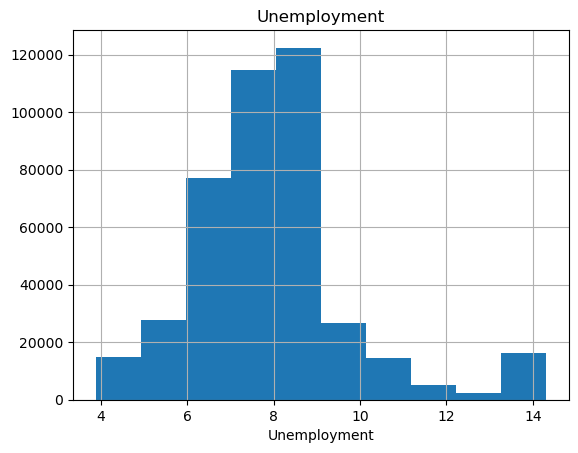

**************************************
count   421570.000
mean    136727.916
std      60980.583
min      34875.000
5%       39690.000
10%      39910.000
20%      70713.000
30%     112238.000
40%     120653.000
50%     140167.000
60%     155083.000
70%     200898.000
80%     203742.000
90%     204184.000
95%     206302.000
99%     219622.000
max     219622.000
Name: Size, dtype: float64


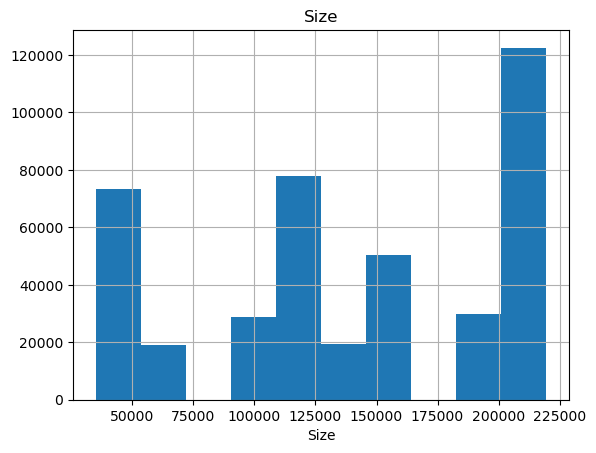

**************************************


In [20]:
for col in num_cols:
    num_summary(df, col, plot=True)

#### KATEGORİK VERİLERLE HEDEF DEĞİŞKEN ANALİZİ

In [21]:
# hedef değişkenin kategorik verilerin kategorisine göre ortalaması ve bazı grafiklerle gösterimi
def target_summary_with_cat(dataframe, target, categorical_col, plot = False):
    print({"TARGET MEAN": pd.DataFrame(dataframe.groupby(categorical_col)[target].mean())})
    if plot:
        # bar plot
        plt.figure(figsize=(10, 6))
        sns.barplot(x=categorical_col, y=target, data=df, estimator=np.mean)
        plt.title(f'{categorical_col} Kategorileri İçin Ortalama {target}')
        plt.show()
        print("*******************************************")
        # box plot
        plt.figure(figsize=(10, 6))
        sns.boxplot(x=categorical_col, y=target, data=df)
        plt.title(f'{categorical_col} Kategorileri İçin Ortalama {target}')
        plt.show()
        print("*******************************************")
        # violin plot
        plt.figure(figsize=(10, 6))
        sns.violinplot(x=categorical_col, y=target, data=df)
        plt.title(f'{categorical_col} Kategorileri İçin Ortalama {target}')
        plt.show()
        print("*******************************************")
        #strip plot
        plt.figure(figsize=(10, 6))
        sns.stripplot(x=categorical_col, y=target, data=df, jitter=True)
        plt.title(f'{categorical_col} Kategorileri İçin Ortalama {target}')
        plt.show()
        print("*******************************************")

{'TARGET MEAN':            Weekly_Sales
IsHoliday              
0             15901.445
1             17035.823}


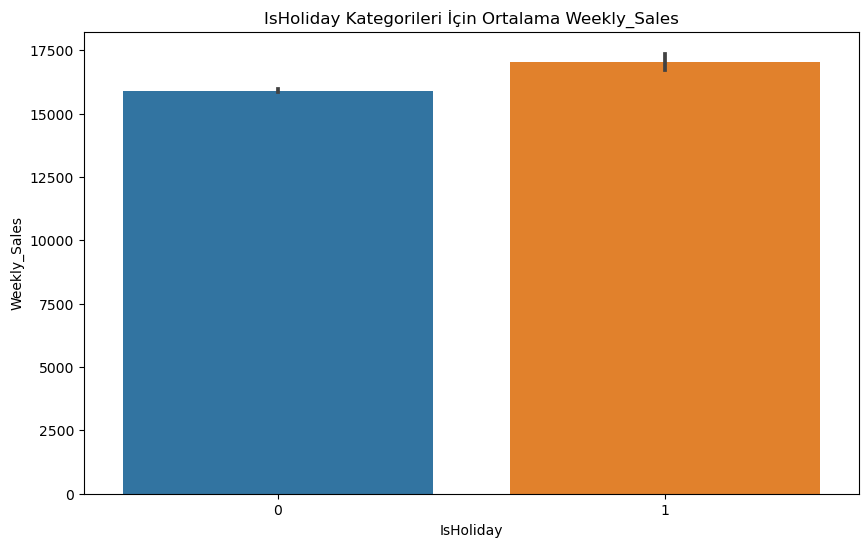

*******************************************


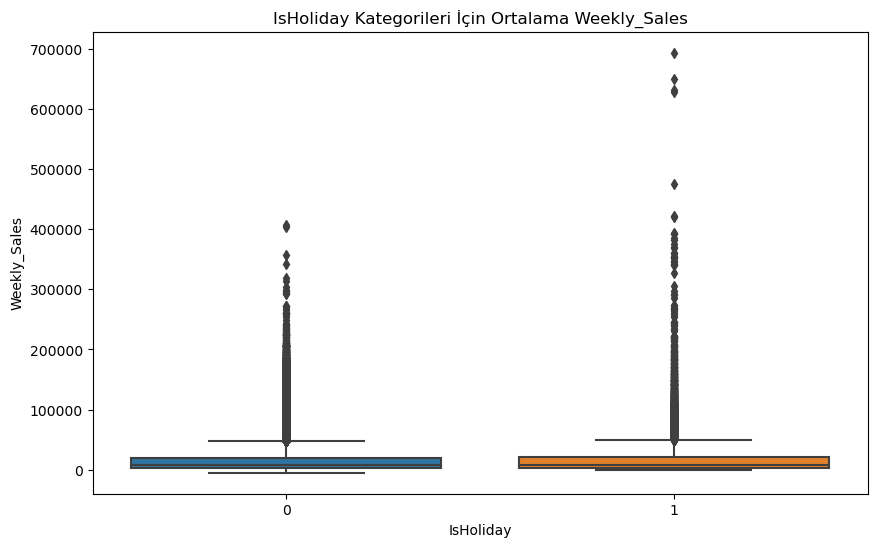

*******************************************


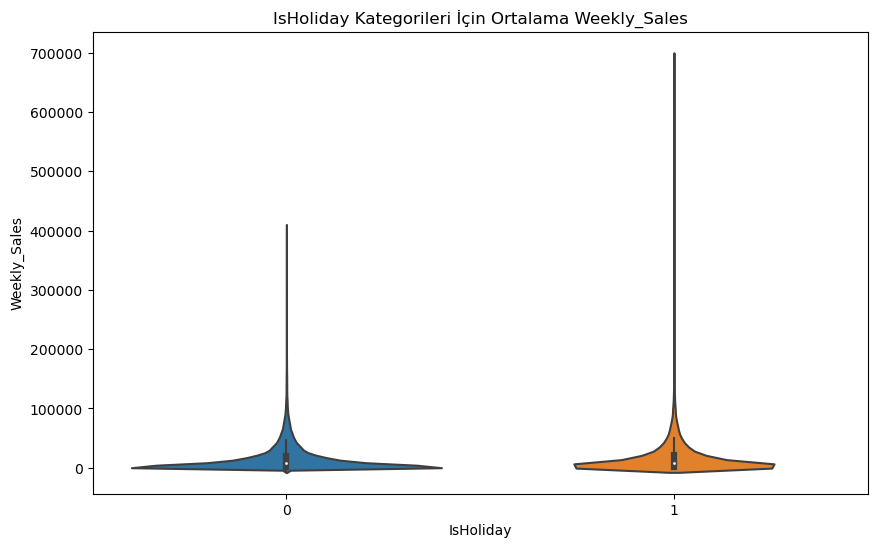

*******************************************


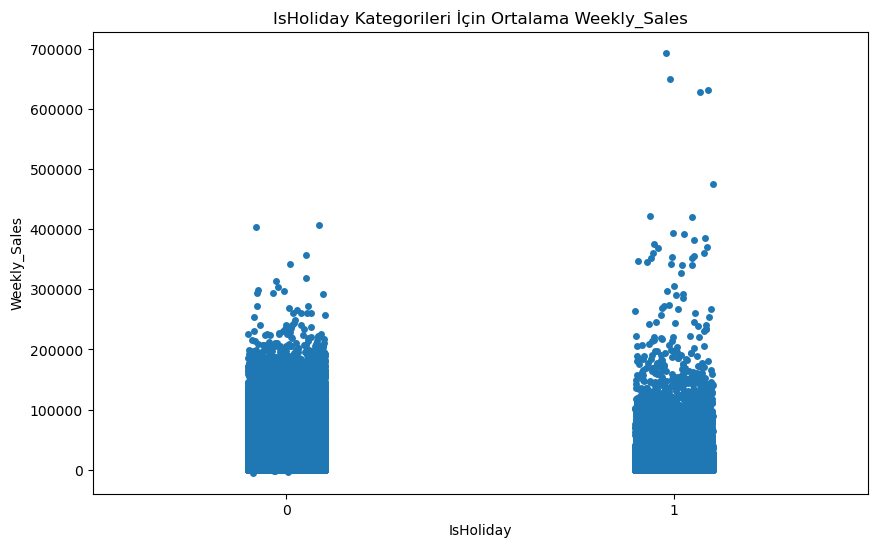

*******************************************
{'TARGET MEAN':       Weekly_Sales
Type              
A        20099.568
B        12237.076
C         9519.533}


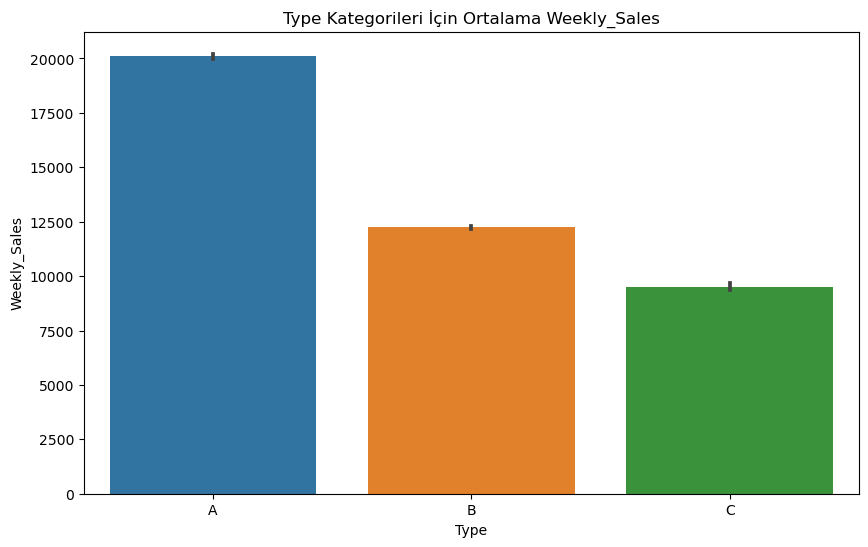

*******************************************


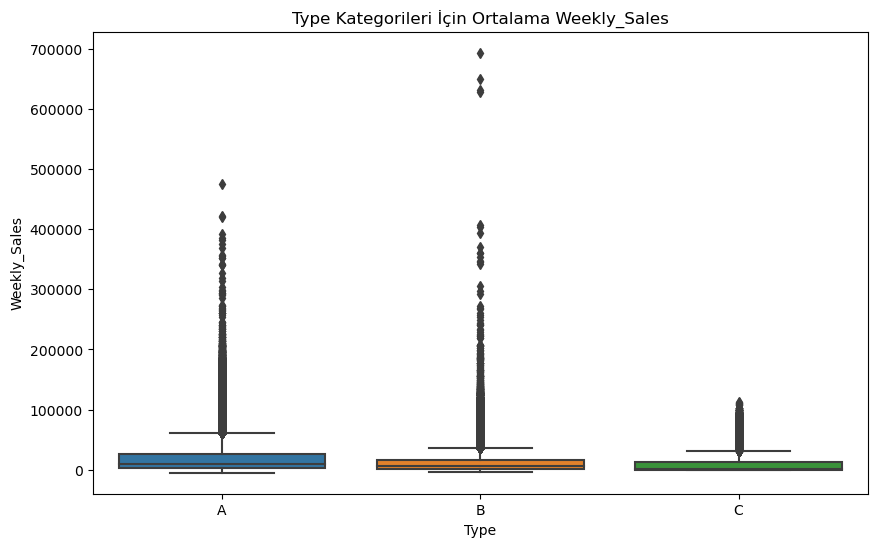

*******************************************


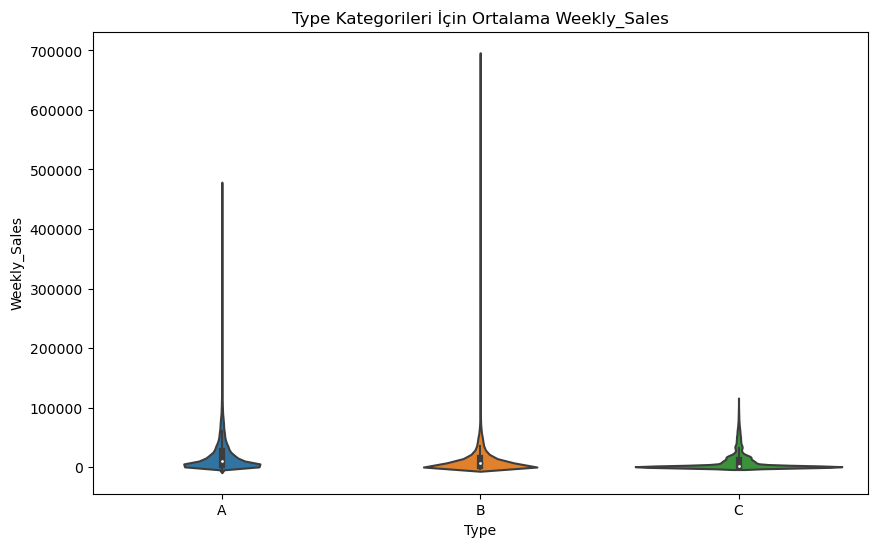

*******************************************


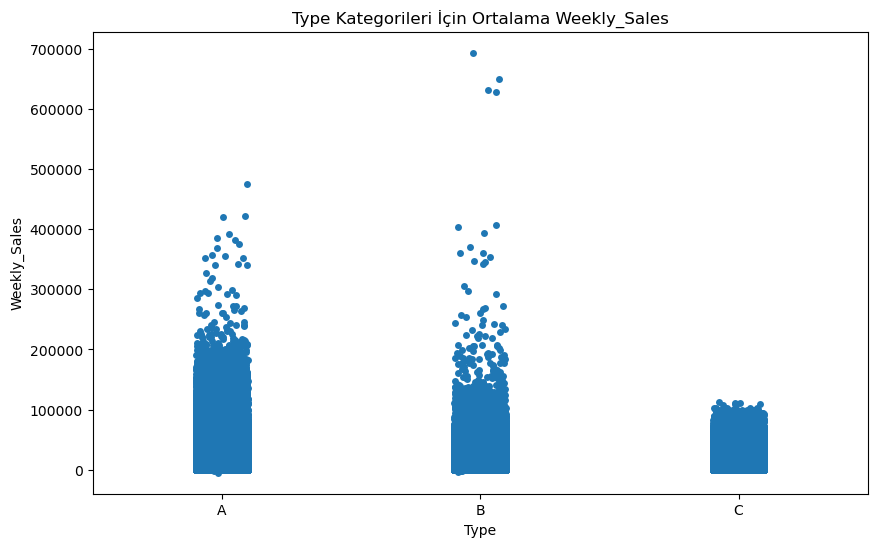

*******************************************
{'TARGET MEAN':        Weekly_Sales
Store              
1         21710.544
2         26898.070
3          6373.034
4         29161.210
5          5053.416
6         21913.244
7          8358.766
8         13133.015
9          8772.890
10        26332.304
11        19276.763
12        14867.309
13        27355.137
14        28784.852
15         9002.493
16         7863.224
17        12954.394
18        15733.313
19        20362.127
20        29508.302
21        11283.435
22        15181.219
23        19776.181
24        18969.106
25        10308.158
26        14554.130
27        24826.985
28        18714.890
29         8158.811
30         8764.238
31        19681.907
32        16351.622
33         5728.414
34        13522.082
35        13803.597
36         8584.413
37        10297.355
38         7492.478
39        21000.764
40        13763.633
41        17976.005
42        11443.370
43        13415.114
44         6038.930
45        11662.897}

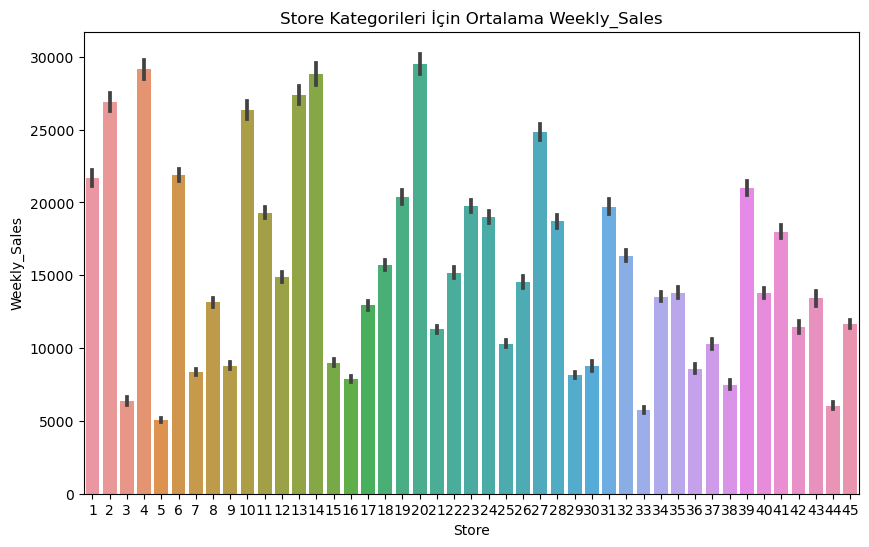

*******************************************


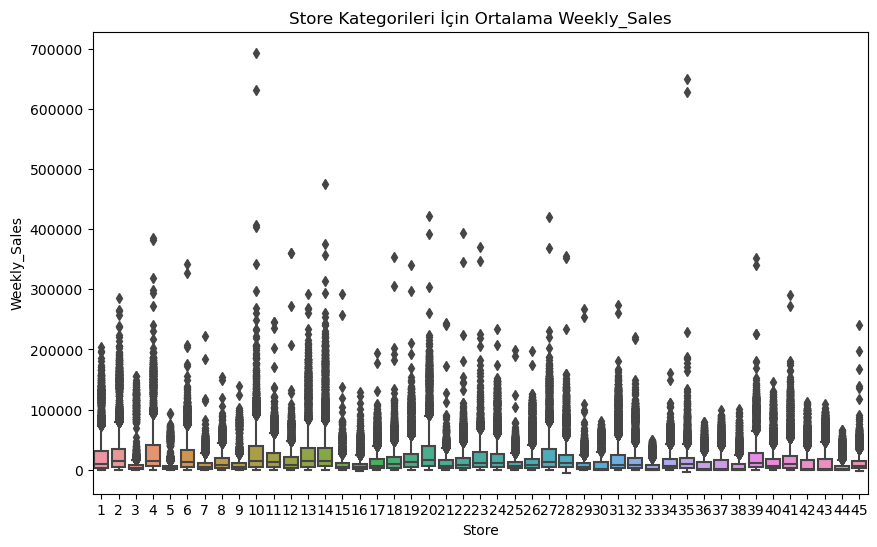

*******************************************


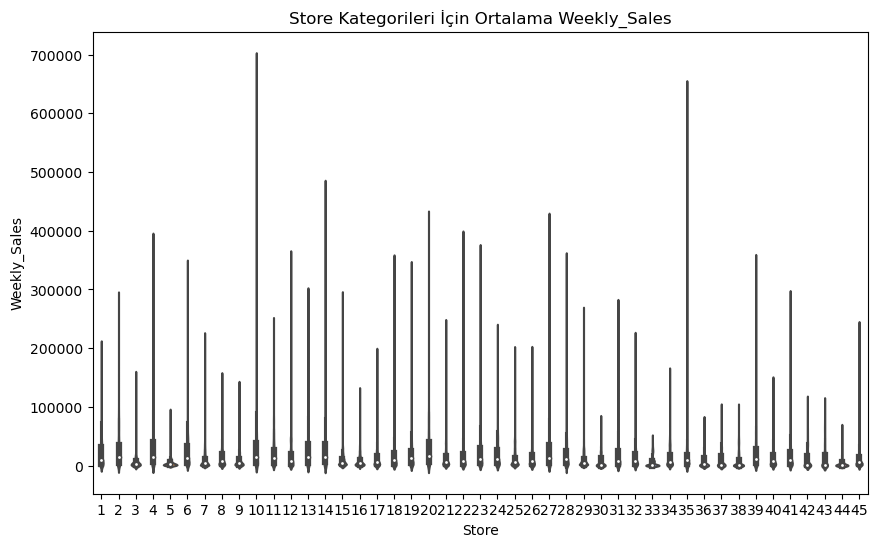

*******************************************


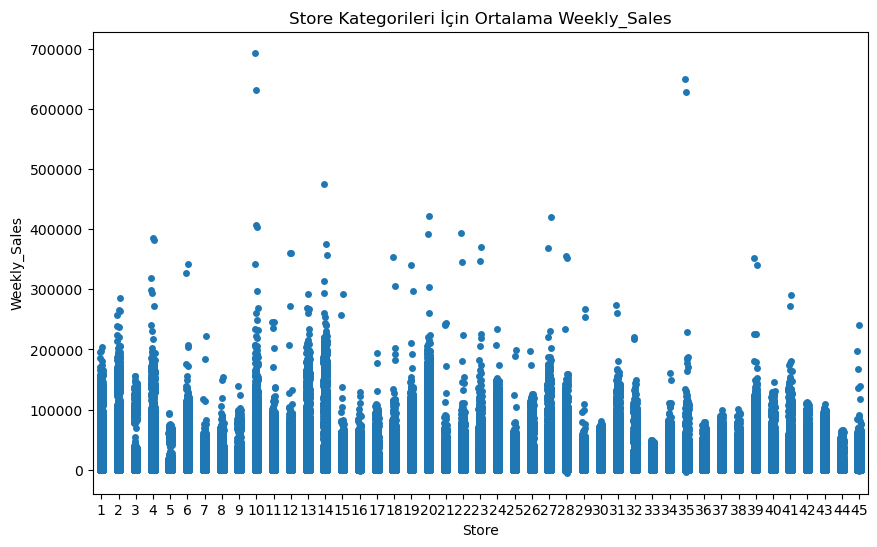

*******************************************
{'TARGET MEAN':       Weekly_Sales
Dept              
1        19213.485
2        43607.020
3        11793.699
4        25974.630
5        21365.584
6         4747.856
7        24161.237
8        30191.264
9        20206.682
10       18321.272
11       14505.638
12        4175.397
13       30663.803
14       14870.966
16       14245.638
17       10187.120
18        7336.944
19        1654.815
20        5528.787
21        4982.851
22       10774.510
23       23931.474
24        6353.605
25        8988.231
26        7649.418
27        1583.438
28         618.085
29        5653.655
30        4118.197
31        2339.440
32        6833.271
33        6471.980
34       15625.915
35        2921.045
36        2022.571
37        3111.076
38       61090.620
39          11.124
40       44900.703
41        1965.560
42        5189.703
43           1.193
44        4651.730
45          23.212
46       19944.741
47          -7.683
48        1344.894
49       

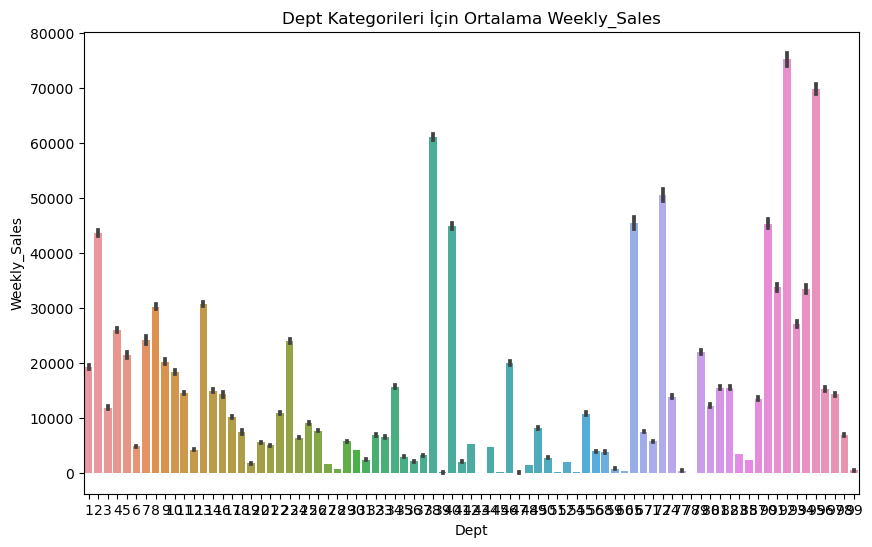

*******************************************


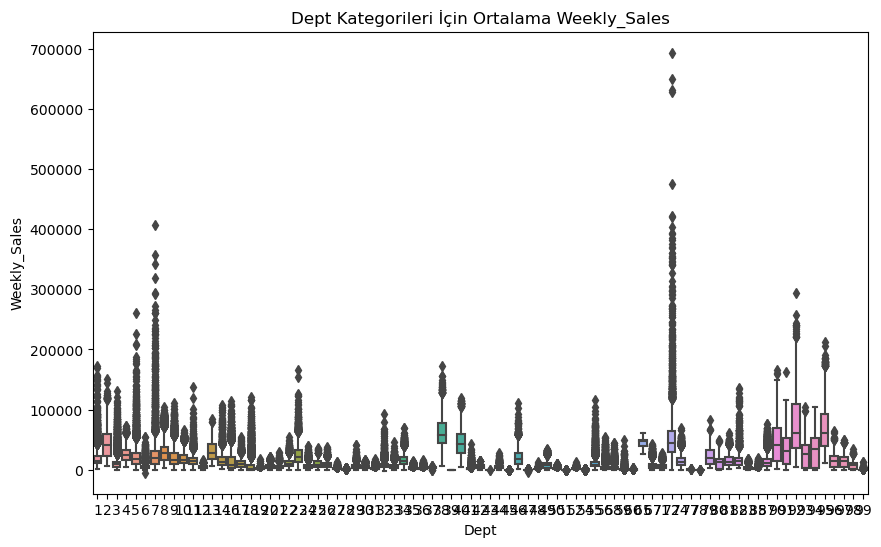

*******************************************


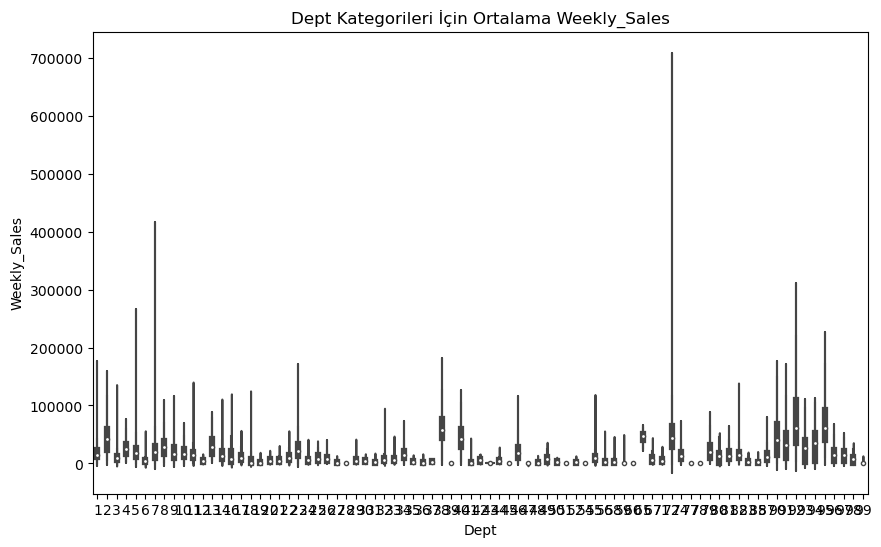

*******************************************


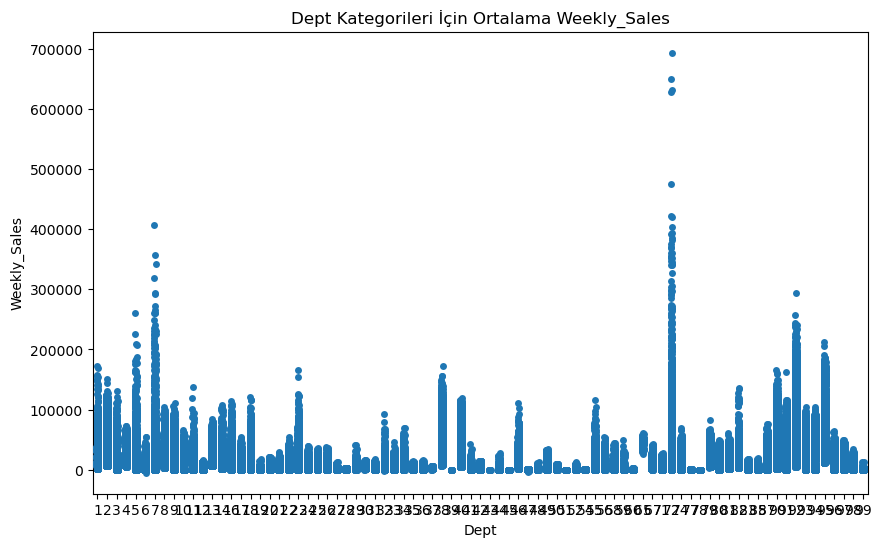

*******************************************
{'TARGET MEAN':      Weekly_Sales
Day              
1       15438.694
2       16282.825
3       16243.592
4       16262.123
5       16152.185
6       16540.153
7       15851.076
8       16026.261
9       16563.237
10      16684.754
11      15946.177
12      15769.984
13      15358.628
14      14843.545
15      15476.566
16      16400.916
17      16890.882
18      15914.848
19      15634.121
20      15236.067
21      14987.075
22      15696.588
23      17183.530
24      17732.369
25      16816.726
26      16742.479
27      14908.183
28      15056.848
29      15117.012
30      15038.411
31      14833.558}


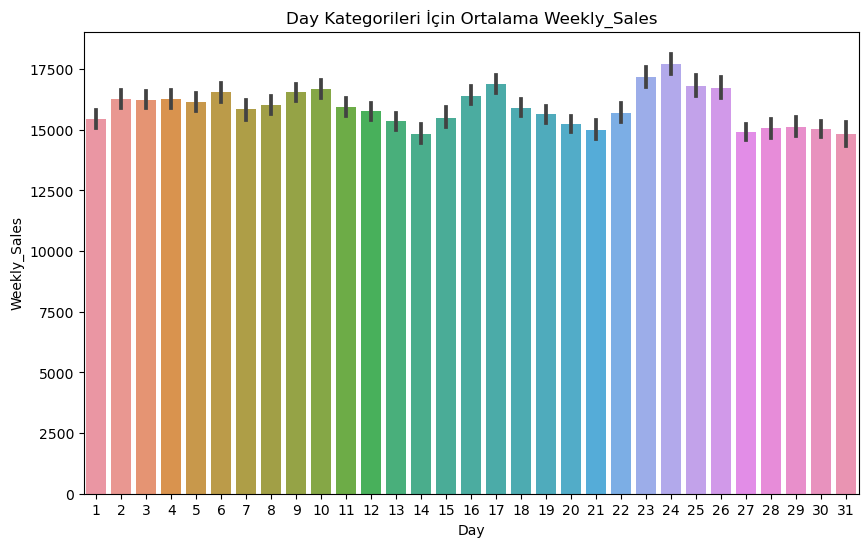

*******************************************


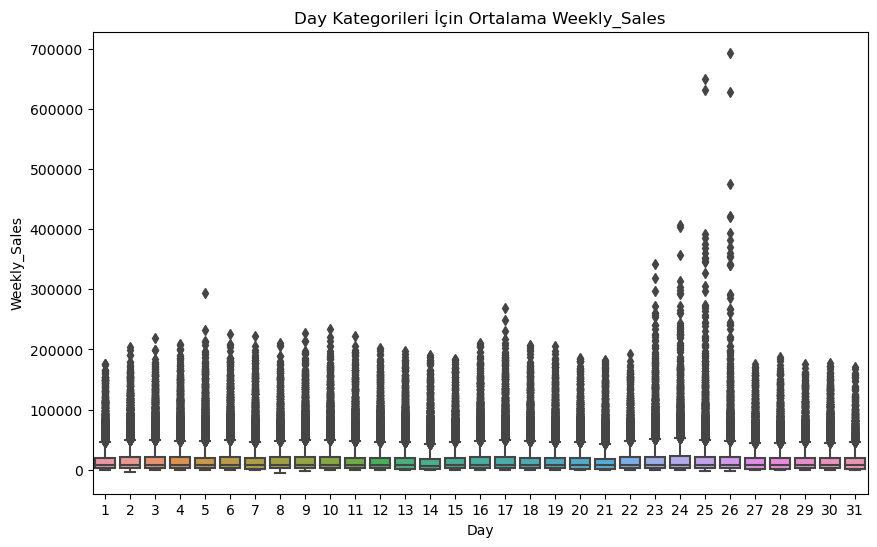

*******************************************


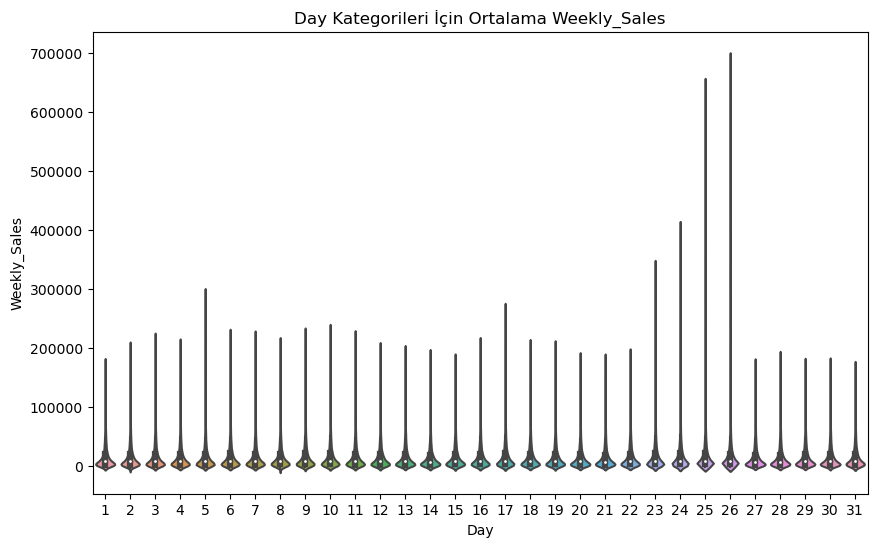

*******************************************


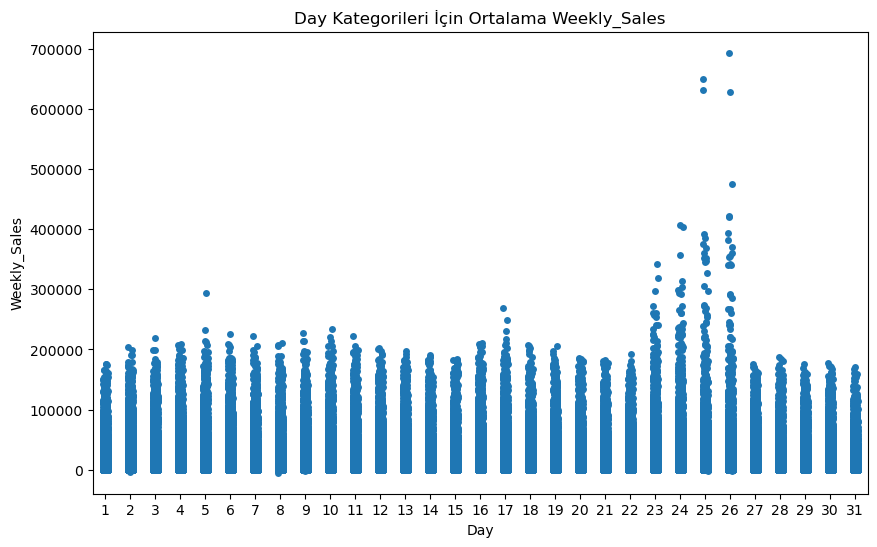

*******************************************
{'TARGET MEAN':        Weekly_Sales
Month              
1         14126.075
2         16008.779
3         15416.658
4         15650.338
5         15776.337
6         16326.137
7         15861.420
8         16062.517
9         15095.886
10        15243.856
11        17491.031
12        19355.702}


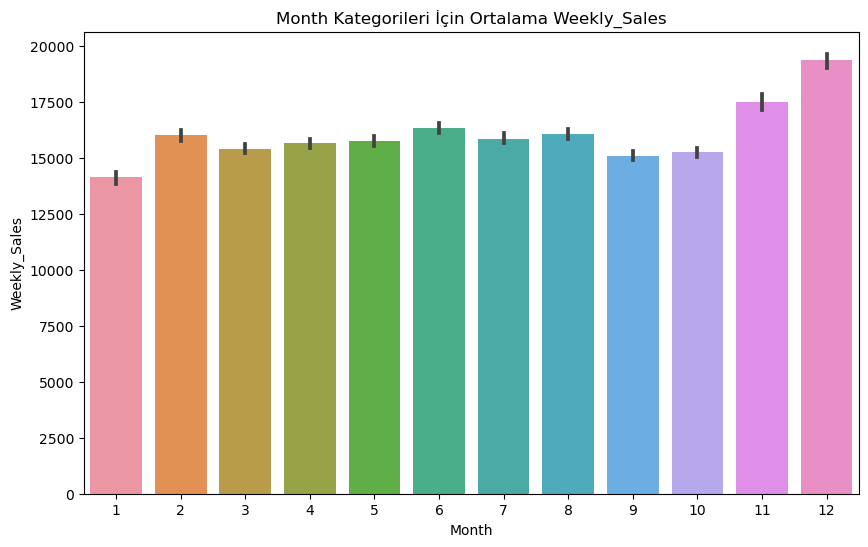

*******************************************


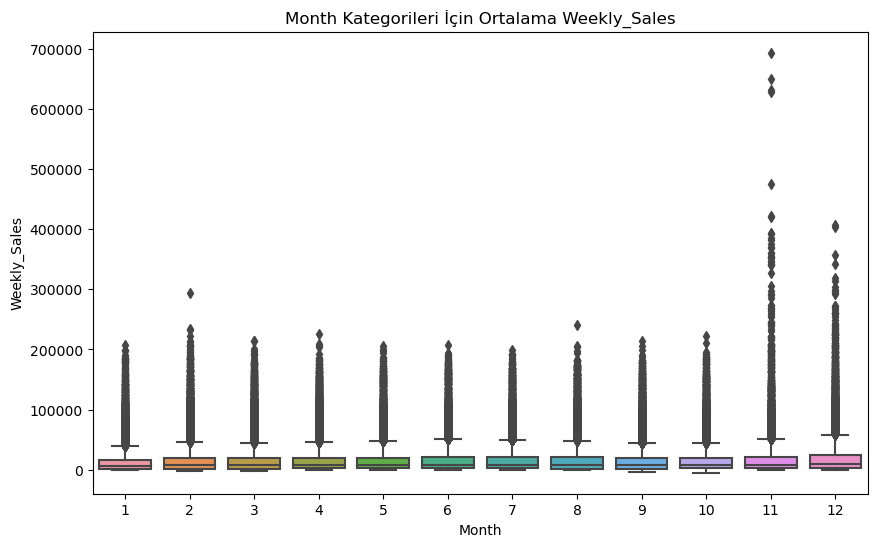

*******************************************


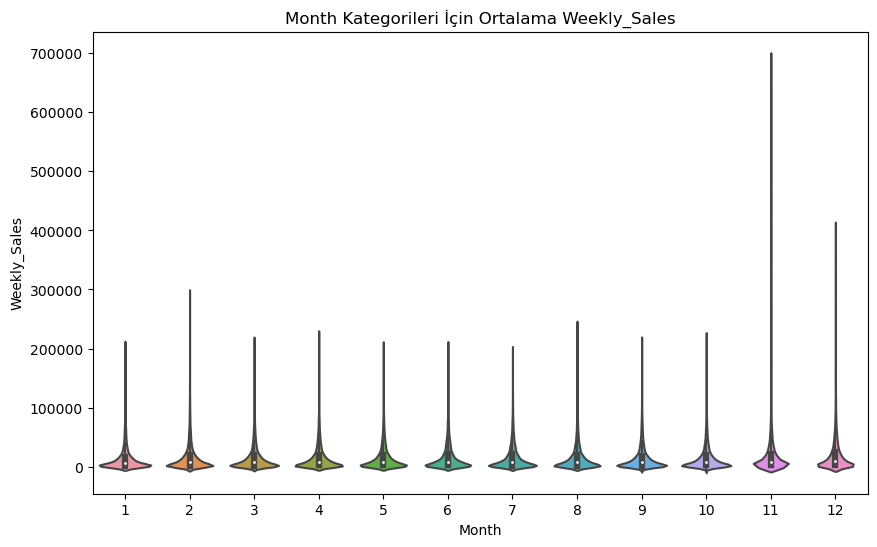

*******************************************


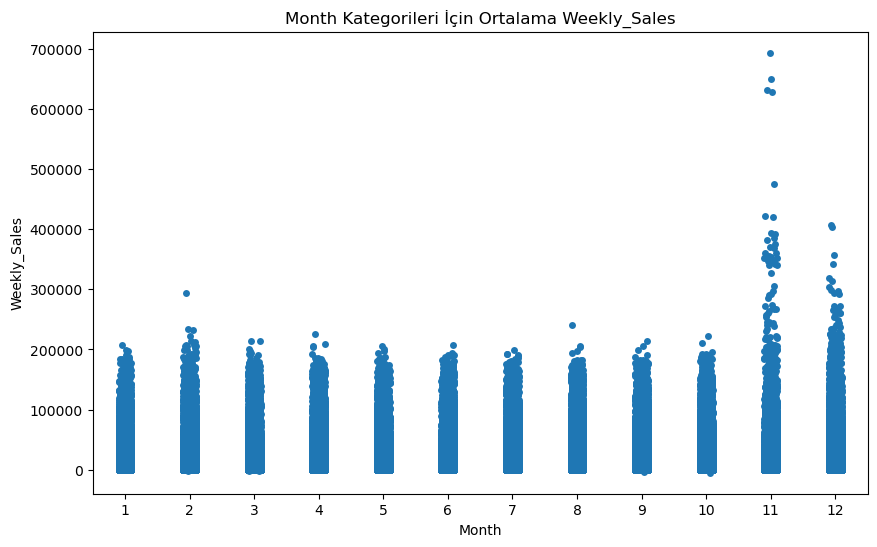

*******************************************
{'TARGET MEAN':       Weekly_Sales
Year              
2010     16270.276
2011     15954.071
2012     15694.949}


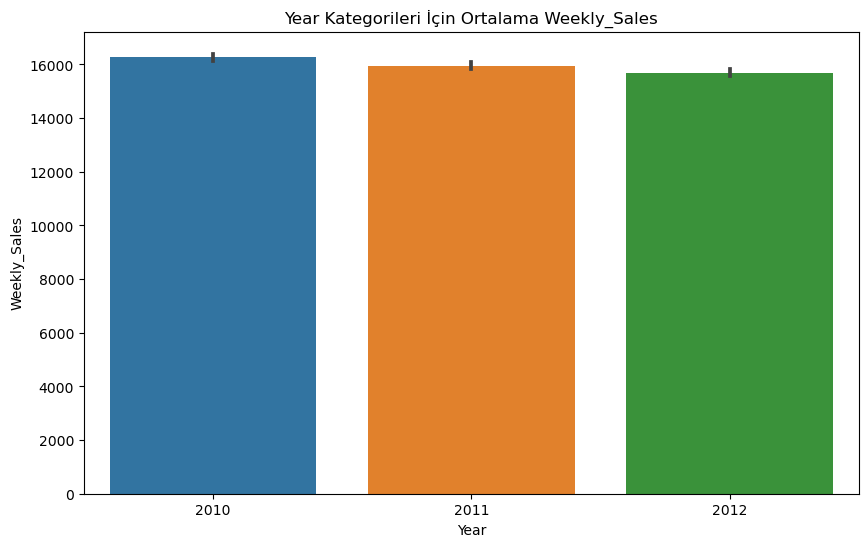

*******************************************


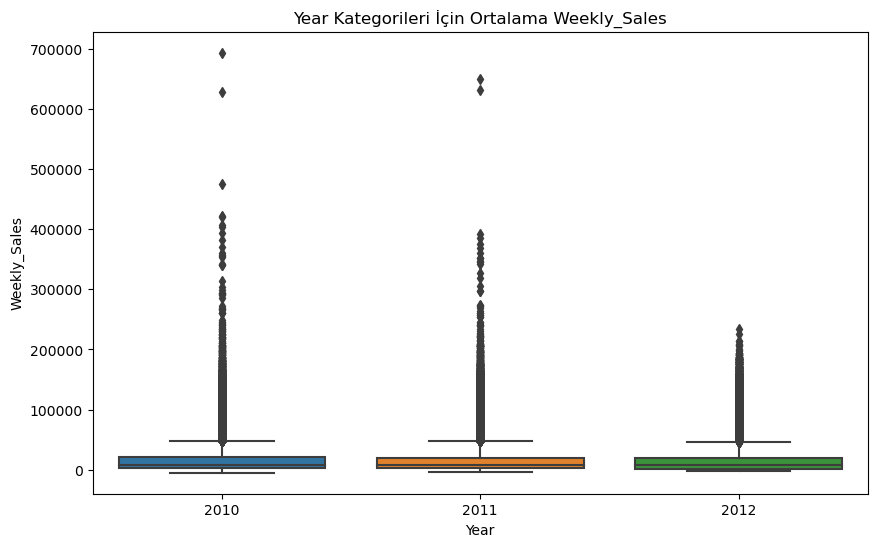

*******************************************


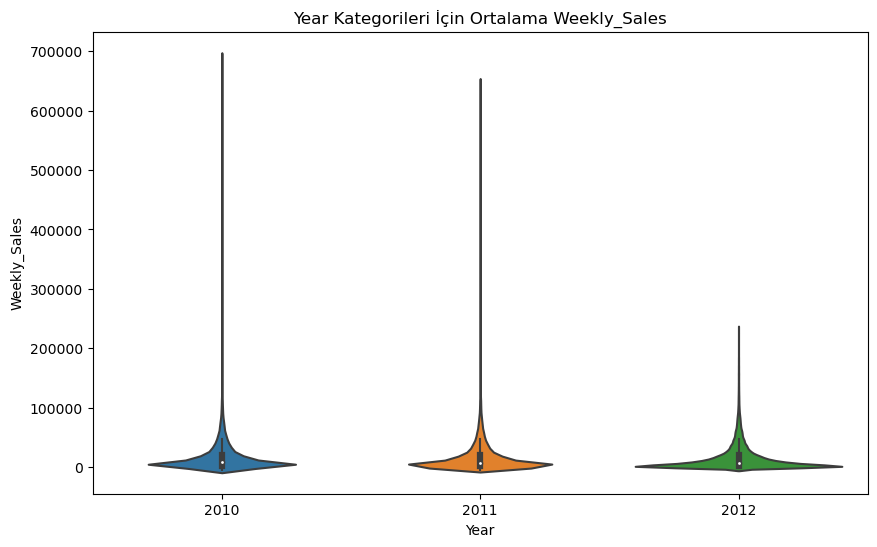

*******************************************


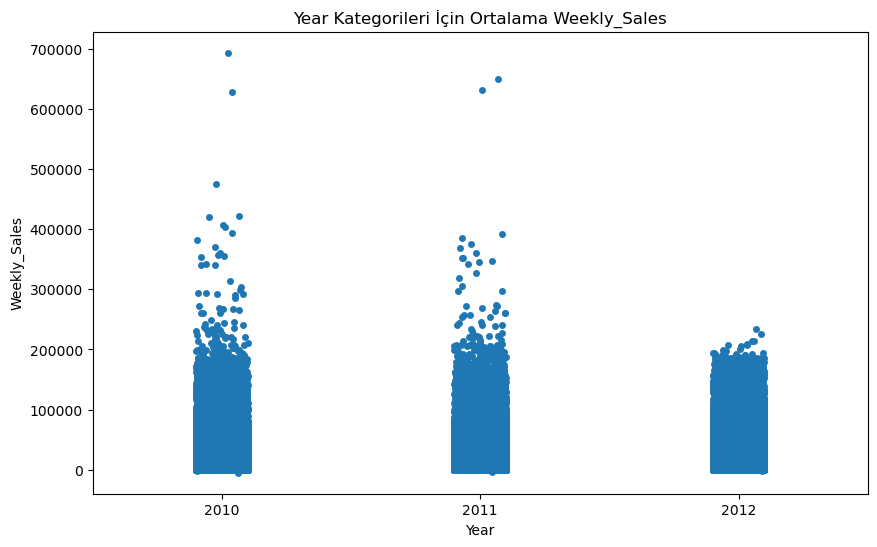

*******************************************


In [22]:
for col in cat_cols:
    target_summary_with_cat(df,"Weekly_Sales", col, plot=True)

Bir de zamana göre ayrıca inceleyelim

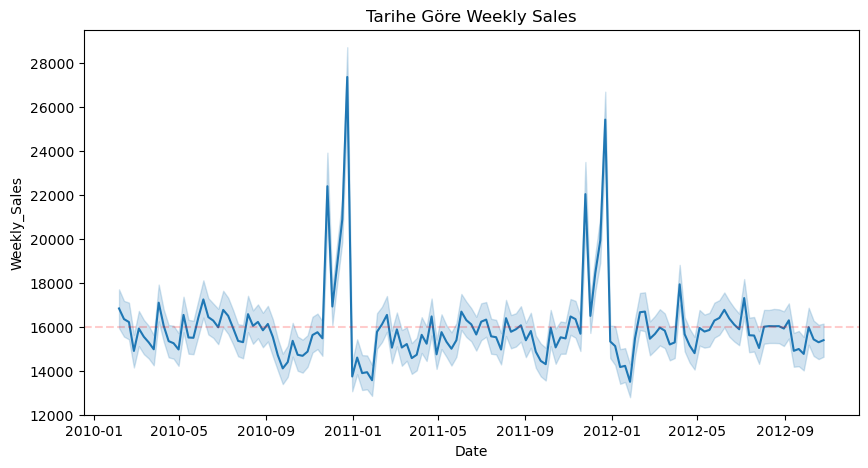

In [23]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=df, x=df.index, y='Weekly_Sales').set_title('Tarihe Göre Weekly Sales')
plt.axhline(df['Weekly_Sales'].mean(), color='r', alpha=0.2, linestyle='--')
plt.show()

#### NUMERİK VERİLERLE HEDEF DEĞİŞKEN ANALİZİ

In [24]:
# hedef değişkenin numerik değişken üzerinde dağılımı
def target_summary_with_num(dataframe,target,numerical_col, plot = False):
    #print(pd.DataFrame(df.groupby(target).agg({numerical_col:"mean"})), end="\n\n\n")
    if plot:
        # scatter plot
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x=numerical_col, y=target, data=df)
        plt.title(f'{numerical_col} ve {target}')
        plt.show()

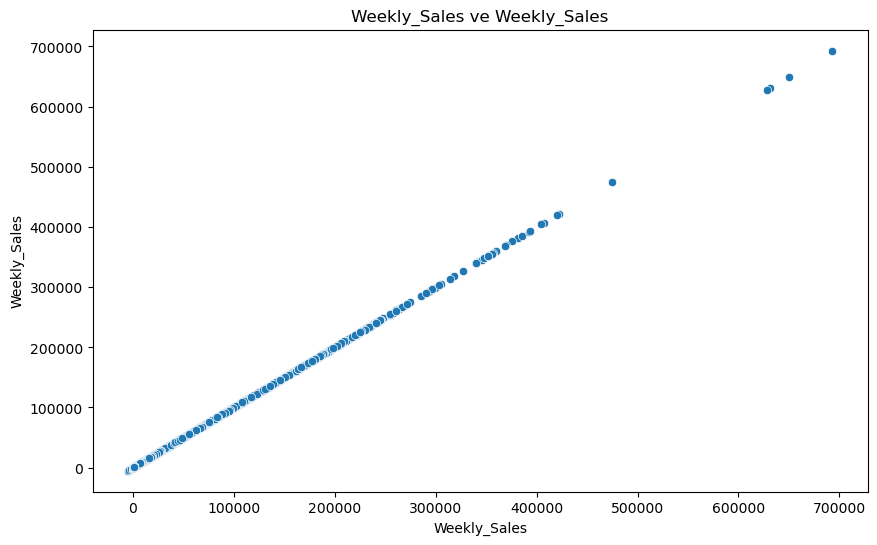

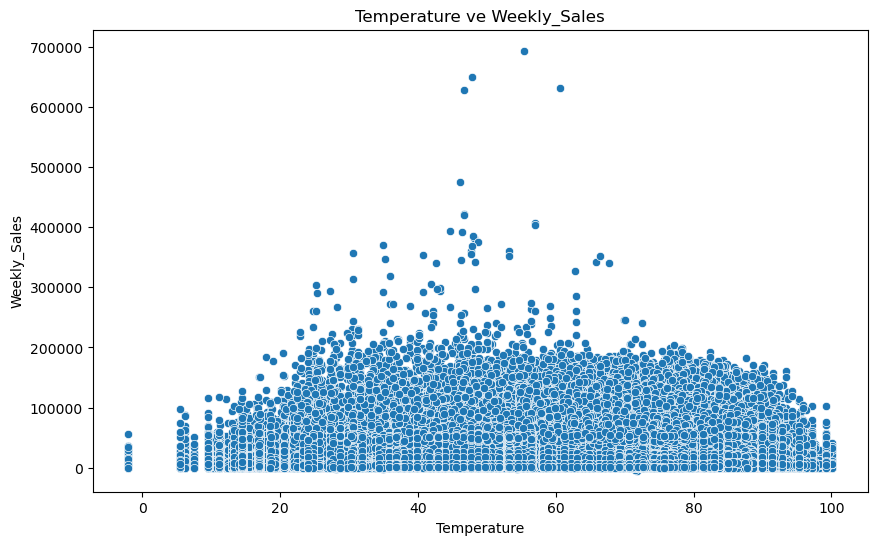

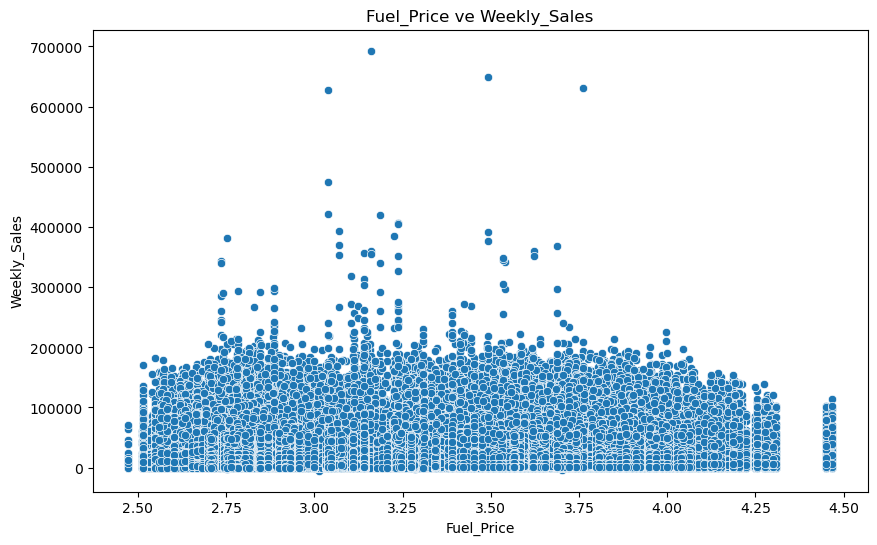

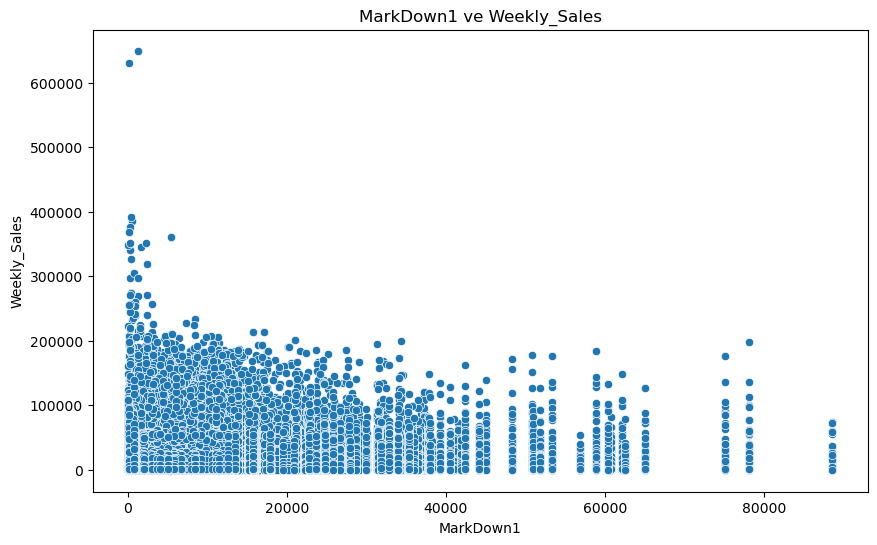

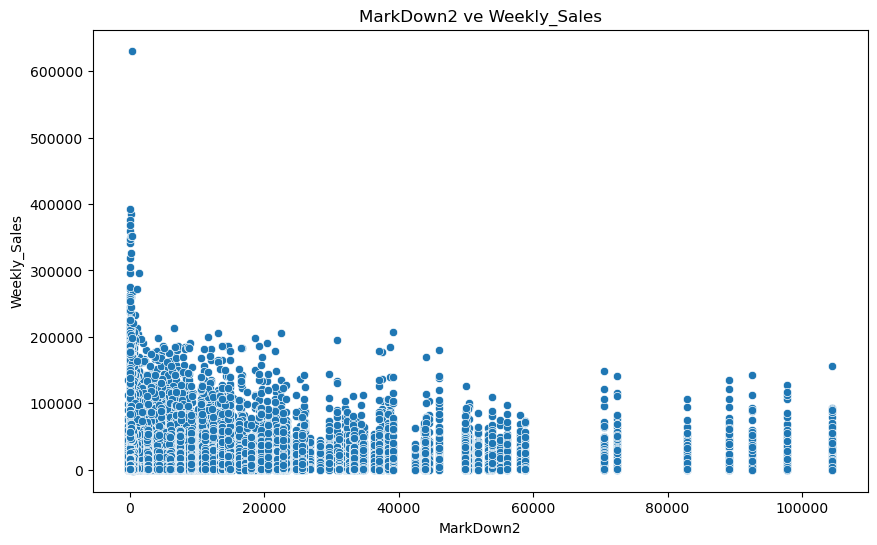

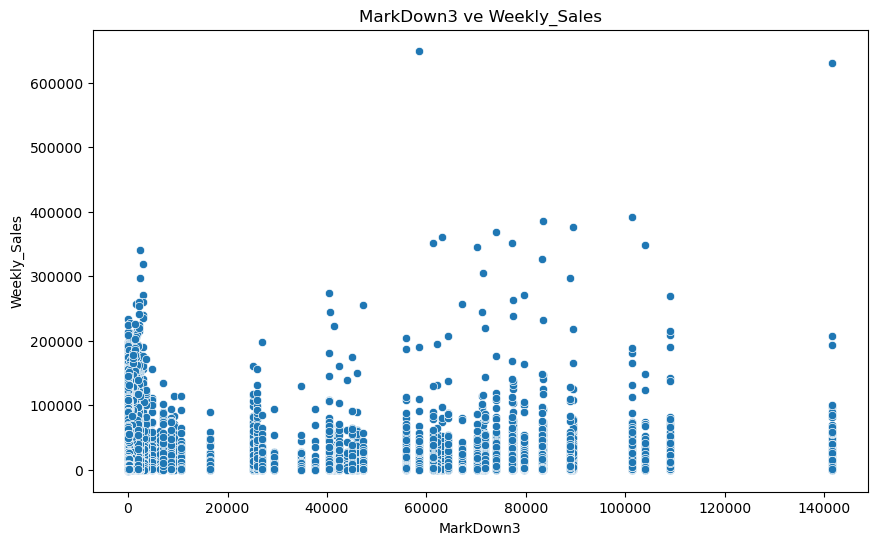

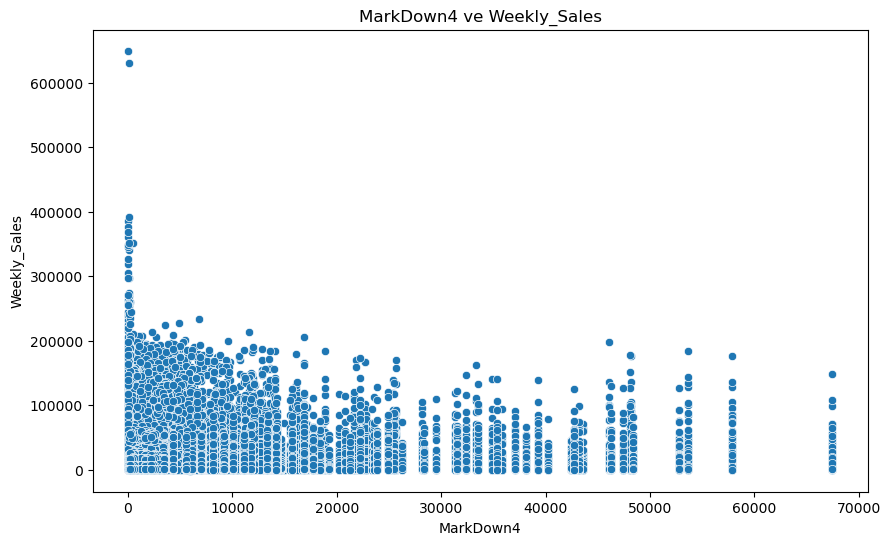

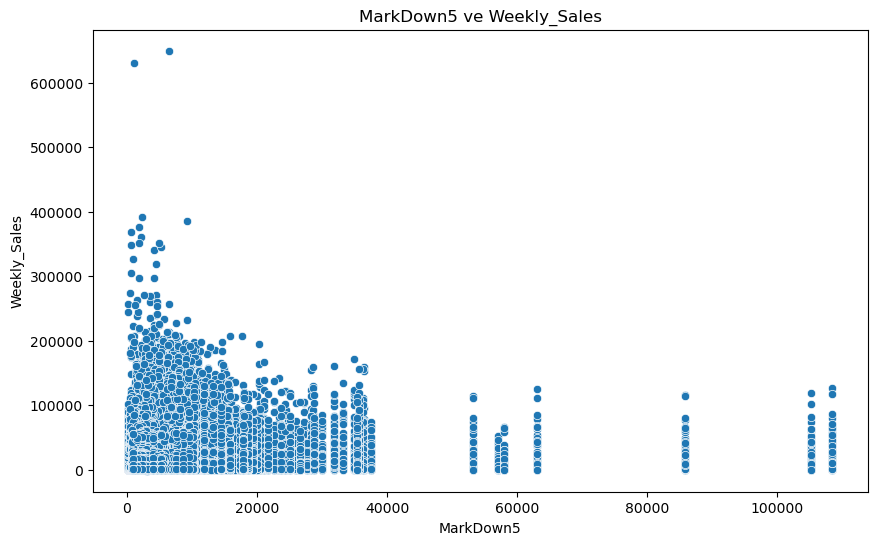

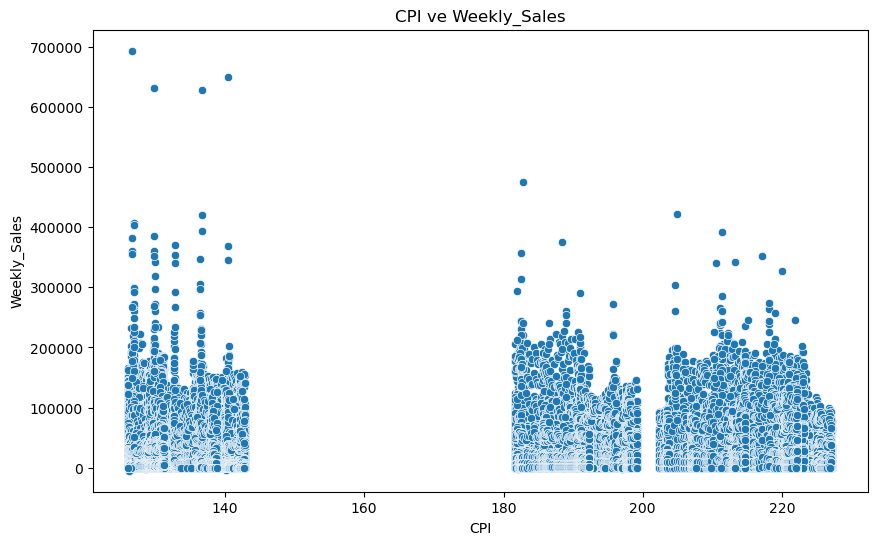

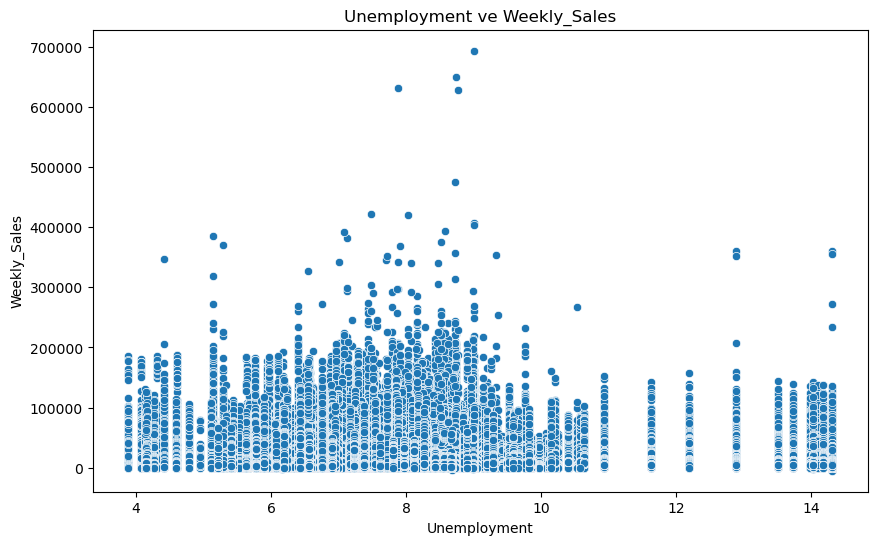

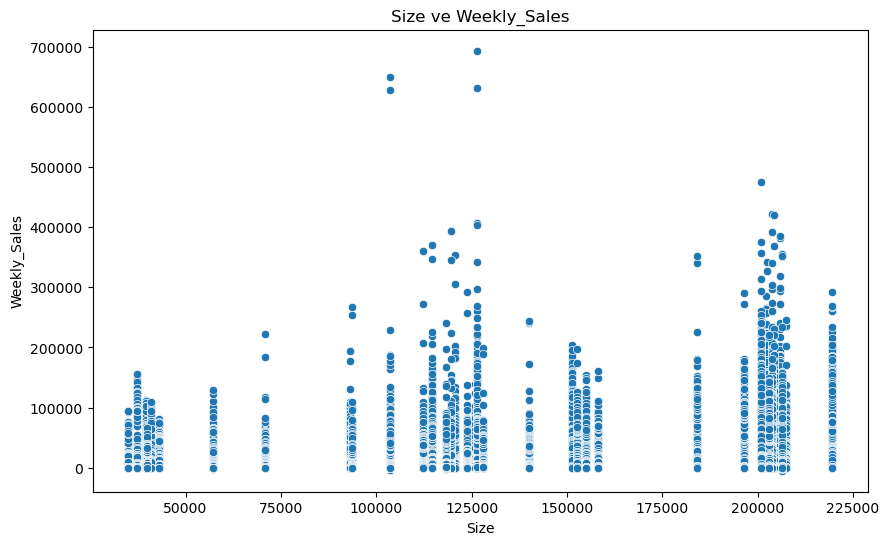

In [25]:
for col in num_cols:
    target_summary_with_num(df,"Weekly_Sales", col, plot=True)

Farklı grafiklerle de inceleyelim.

###### TEMPERATURE DEĞİŞKENİ

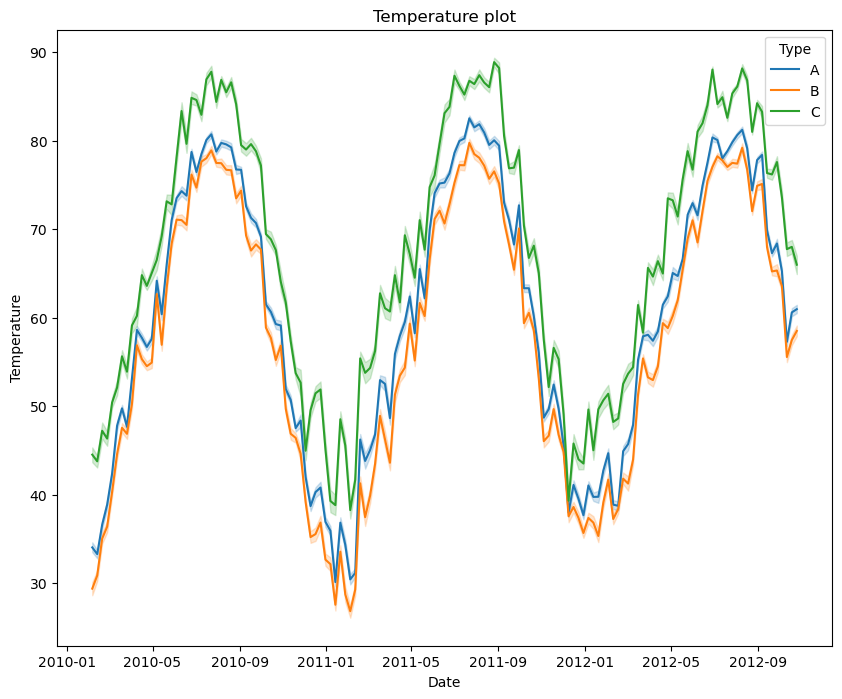

In [26]:
# tarihe göre sıcaklıklar ve type değişkeniyle ilişkisi
fig, ax = plt.subplots(figsize=(10, 8))
sns.lineplot(data=df, x=df.index, y='Temperature', hue='Type', ax=ax).set_title('Temperature plot')
plt.show()

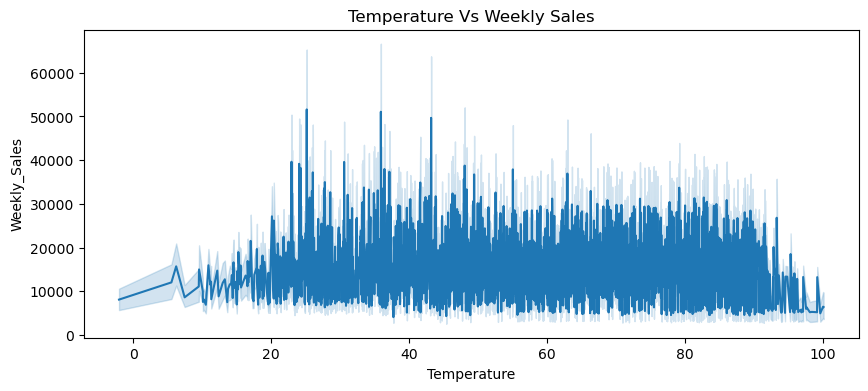

In [27]:
plt.figure(figsize=(10,4))
sns.lineplot(data=df, x='Temperature', y='Weekly_Sales').set_title('Temperature Vs Weekly Sales')
plt.show()

###### FUEL PRICE DEĞİŞKENİ

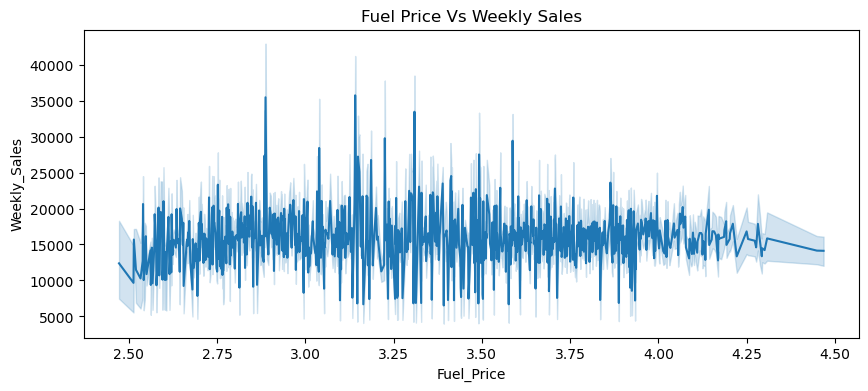

In [28]:
plt.figure(figsize=(10,4))
sns.lineplot(data=df, x='Fuel_Price', y='Weekly_Sales').set_title('Fuel Price Vs Weekly Sales')
plt.show()

###### CPI DEĞİŞKENİ

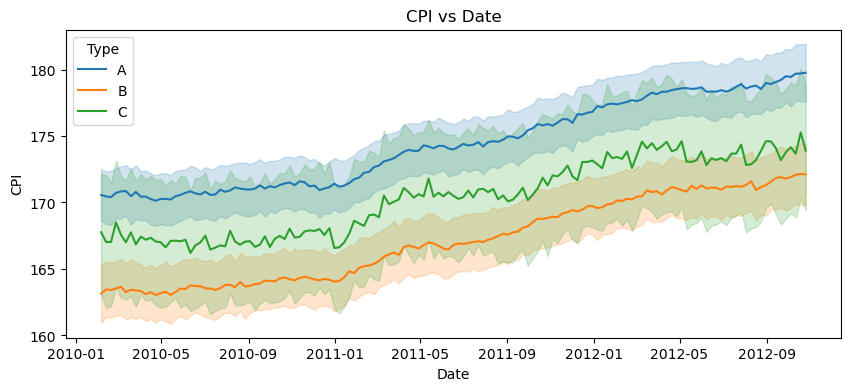

In [29]:
# tarihe göre CPI ve type değişkeniyle ilişkisi
plt.figure(figsize=(10,4))
sns.lineplot(data=df, x='Date', y='CPI', hue='Type').set_title('CPI vs Date')
plt.show()

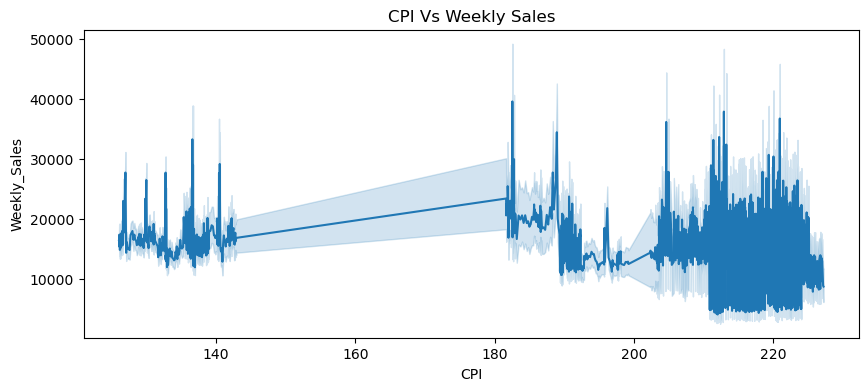

In [30]:
plt.figure(figsize=(10,4))
sns.lineplot(data=df, x='CPI',y='Weekly_Sales').set_title('CPI Vs Weekly Sales')
plt.show()

###### UNEMPLOYEMENT DEĞİŞKENİ

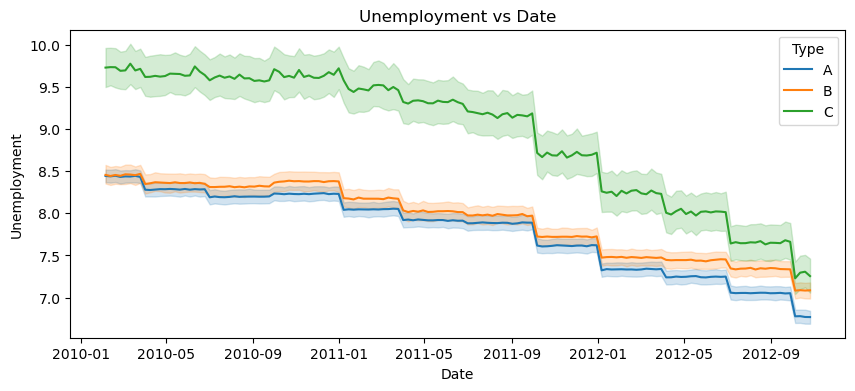

In [31]:
# tarihe göre CPI ve type değişkeniyle ilişkisi
plt.figure(figsize=(10,4))
sns.lineplot(data=df, x='Date', y='Unemployment', hue='Type').set_title('Unemployment vs Date')
plt.show()

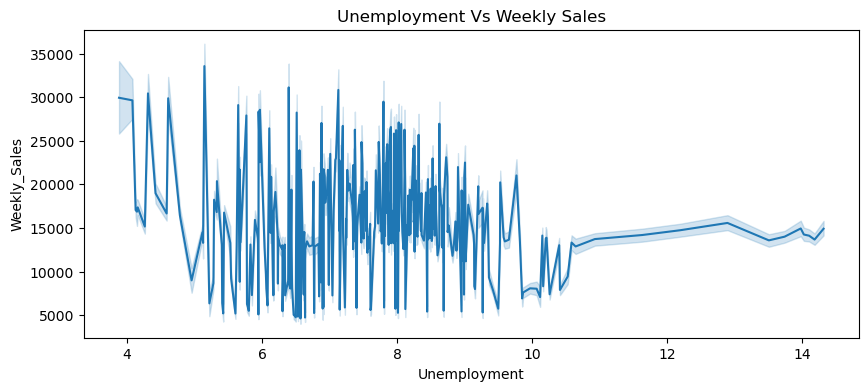

In [32]:
plt.figure(figsize=(10,4))
sns.lineplot(data=df, x='Unemployment',y='Weekly_Sales').set_title('Unemployment Vs Weekly Sales')
plt.show()

### DEĞİŞKENLERİN KORELASYON ANALİZİ

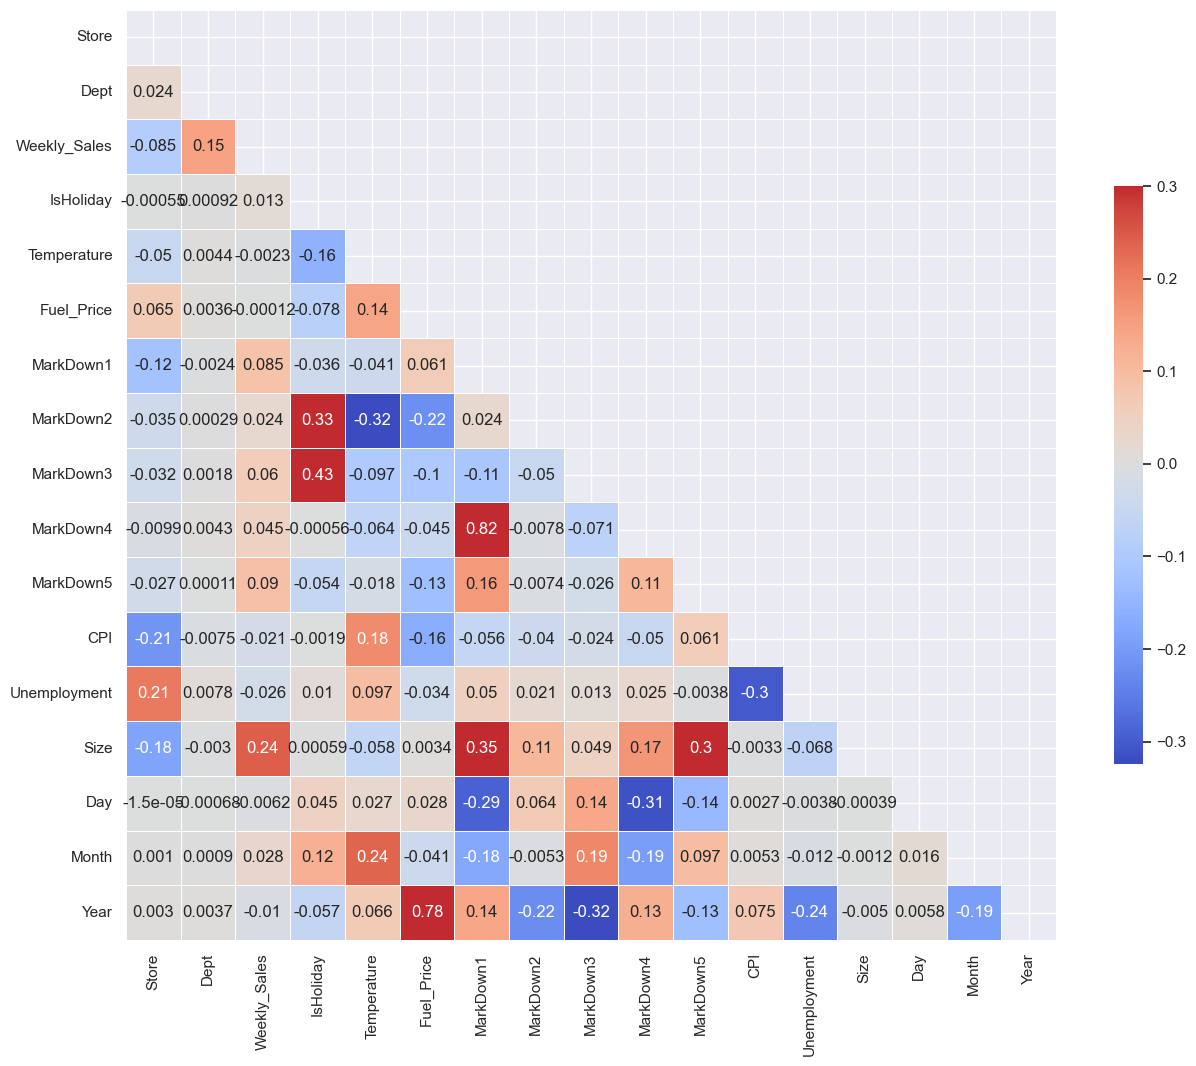

In [33]:
# değişkenlerin biribiryle korelasyonu
def high_correlated_cols(dataframe, cor_th= 0.9, plot=False):
    corr = dataframe.corr(numeric_only= True)
    cor_matrix = corr.abs() #negatif veya pozitif korelasyon fark etmediği için mutlak değerlerini alıyorum öncelikle
    upper_triangle_matrix=cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool)) # oluşturduğumuz matriste 0.9'dan büyük korelasyonu olan değişkenleri seçip drop_list'e attık.
    drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] > cor_th)] #oluşturduğumuz matriste 0.9'dan büyük korelasyonu olan değişkenleri seçip drop_list'e attık.
    if plot:
        import seaborn as sns
        import matplotlib.pyplot as plt
        sns.set(rc={"figure.figsize": (15, 15)})
        mask = np.triu(np.ones_like(corr, dtype=bool))
        sns.heatmap(corr, cmap="coolwarm", annot= True, mask=mask, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
        plt.show()
    return drop_list

drop_list = high_correlated_cols(df, plot=True)
#df.drop(drop_list,axis = 1)

In [34]:
drop_list  #0.9 eşik değerinin üstünde korelasyonu olan veri olmadığı için boş liste.

[]

### OUTLIER ANALİZİ

In [195]:
# iqr değerini hesaplayıp limitleri oluşturuyoruz. dışında kalanlar outlier.
def outlier_thresholds(dataframe, col_name, q1=0.1, q3=0.98):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [196]:
#outliers var mı yok mu kontrol fonksiyonu. true or false döndürür. içinde outlier_thresholds() fonksiyonunu da kullanır.
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [197]:
for col in num_cols:
    print(col, check_outlier(df, col))

Weekly_Sales True
Temperature False
Fuel_Price False
MarkDown1 True
MarkDown2 True
MarkDown3 True
MarkDown4 True
MarkDown5 True
CPI False
Unemployment False
Size False


In [204]:
low, up= outlier_thresholds(df, "Weekly_Sales")

In [205]:
print("Low limit:", low)
print("Up limit:", up)

Low limit: -126665.30270000003
Up limit: 211935.50450000004


###### outlierları belirleyeceğim noktalara karar verebilmek için bazı görselleştirmeler yapıyorum.

###### Weekly Sales Outlier

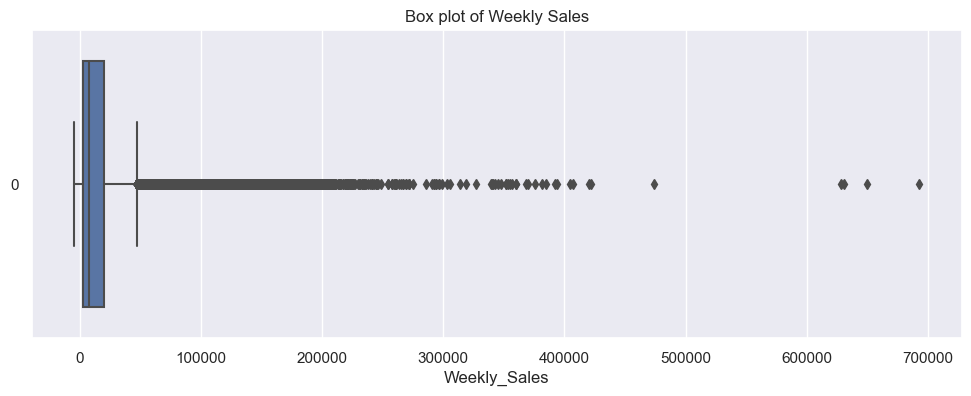

In [60]:
plt.figure(figsize=(12,4))
sns.boxplot(df['Weekly_Sales'], orient='h')
plt.xlabel('Weekly_Sales')
plt.title('Box plot of Weekly Sales')
plt.show()

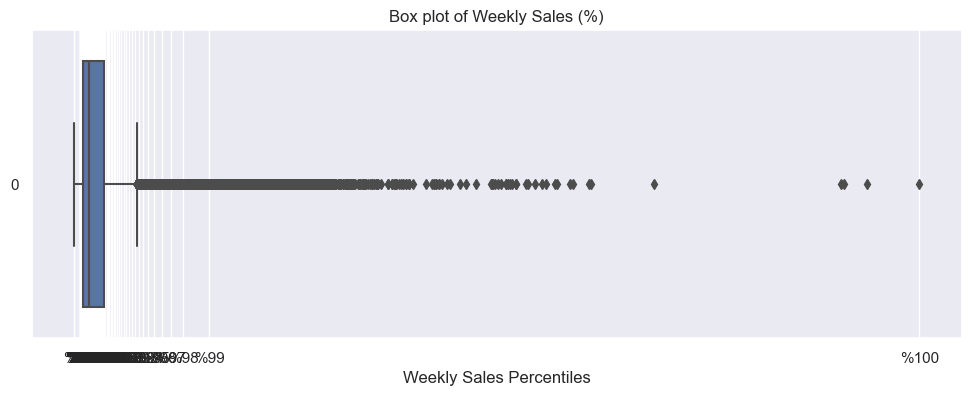

In [68]:
percentiles = np.percentile(df['Weekly_Sales'], np.arange(0, 101, 1))
plt.figure(figsize=(12, 4))
sns.boxplot(df['Weekly_Sales'], orient='h')
plt.xticks(percentiles, [f"%{i}" for i in range(0, 101, 1)])
plt.xlabel('Weekly Sales Percentiles')
plt.title('Box plot of Weekly Sales (%)')
plt.show()

Weekly Sales değişkeninin neyi ifade ettiğini bildiğim için manuel olarak yorum yapabiliyorum.
0'dan küçük satış değerleri normal olmadığı için ve veriyi bozacağından kaldıracağım.
200000'den büyük değerleri de grafiklere bakınca outlier olarak görüyorum. Kaldıracağım.

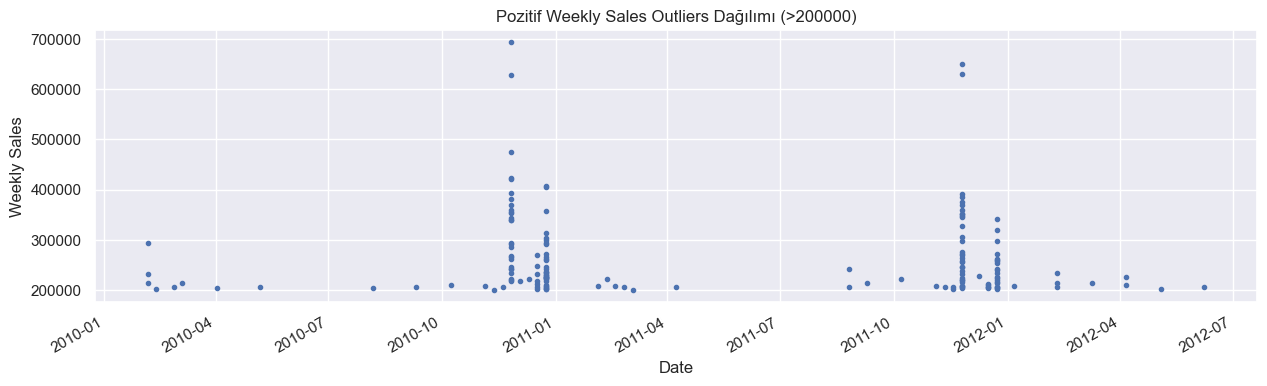

In [85]:
wsp_outliers = df.query('Weekly_Sales > 200000')
wsp_outliers['Weekly_Sales'].plot(figsize=(15, 4), style='.')
plt.ylabel('Weekly Sales')
plt.title('Pozitif Weekly Sales Outliers Dağılımı (>200000)')
plt.show()

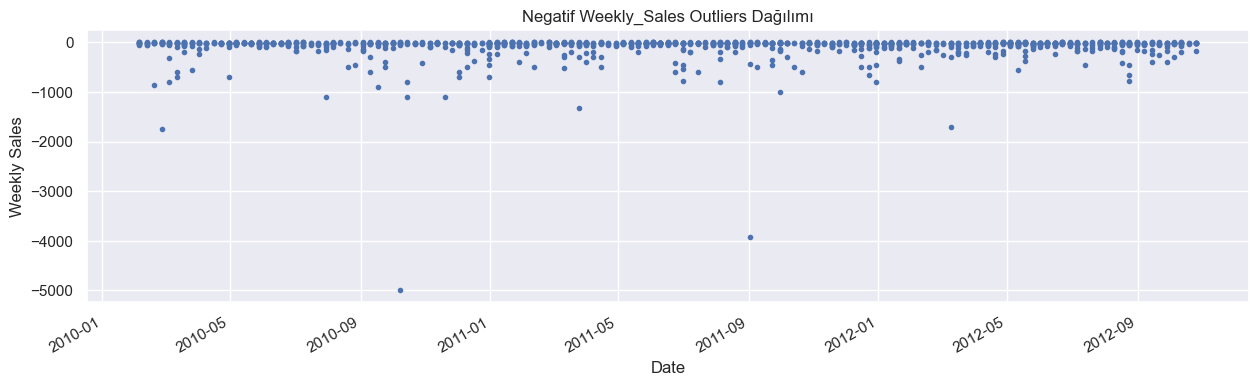

In [87]:
wsn_outliers = df.query('Weekly_Sales <= 0')
wsn_outliers['Weekly_Sales'].plot(figsize=(15, 4), style='.')
plt.ylabel('Weekly Sales')
plt.title('Negatif Weekly_Sales Outliers Dağılımı')
plt.show()

In [86]:
wsp_outliers.shape

(163, 18)

In [88]:
wsn_outliers.shape

(1358, 18)

In [90]:
wsp_outliers.shape[0] +  wsn_outliers.shape[0]

1521

belirlediğim outlier değerler verinin  %0.36'sını oluşturuyor. Yani silmek sorun olmaz.

In [119]:
new_df = df.query('Weekly_Sales >= 0 and Weekly_Sales < 200000')
new_df.shape

(420122, 18)

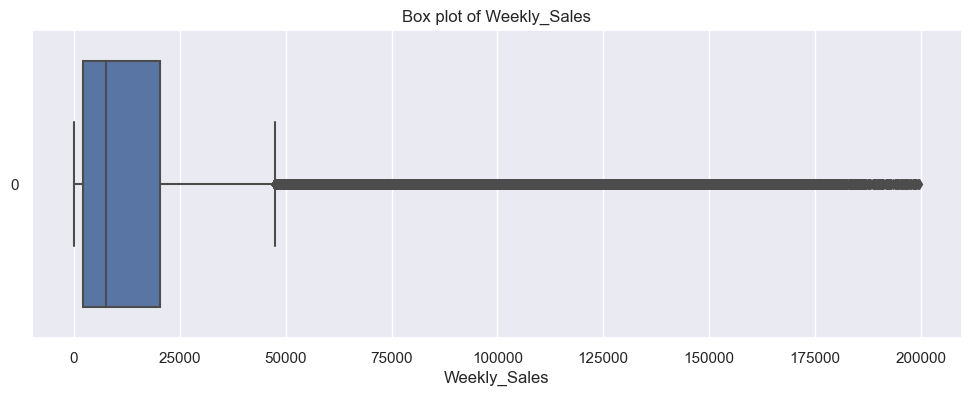

In [120]:
#yeni haline bakalım
plt.figure(figsize=(12,4))
sns.boxplot(new_df['Weekly_Sales'], orient='h')
plt.xlabel('Weekly_Sales')
plt.title('Box plot of Weekly_Sales')
plt.show()

###### MarkDown Değişkenleri Outlier Tespiti

In [161]:
def plot_markdown_boxplots(df, columns):
    for column in columns:
        plt.figure(figsize=(12, 4))
        sns.boxplot(df[column], orient='h')
        plt.xlabel(column)
        plt.title(f'Box plot of {column}')
        plt.show()

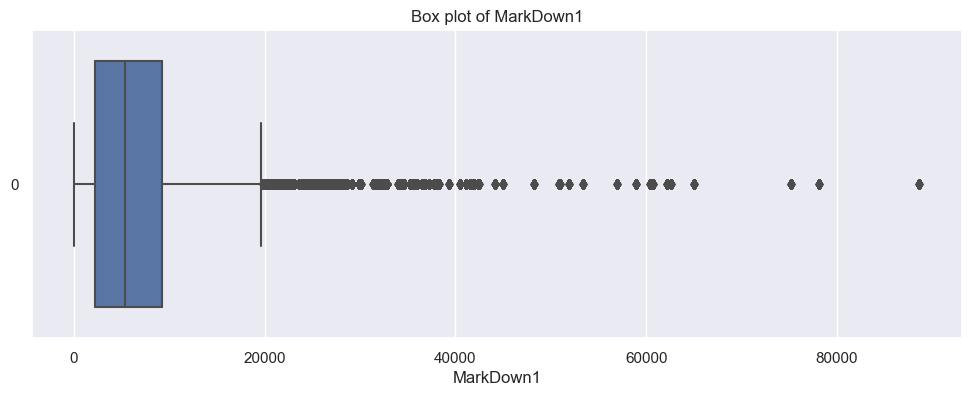

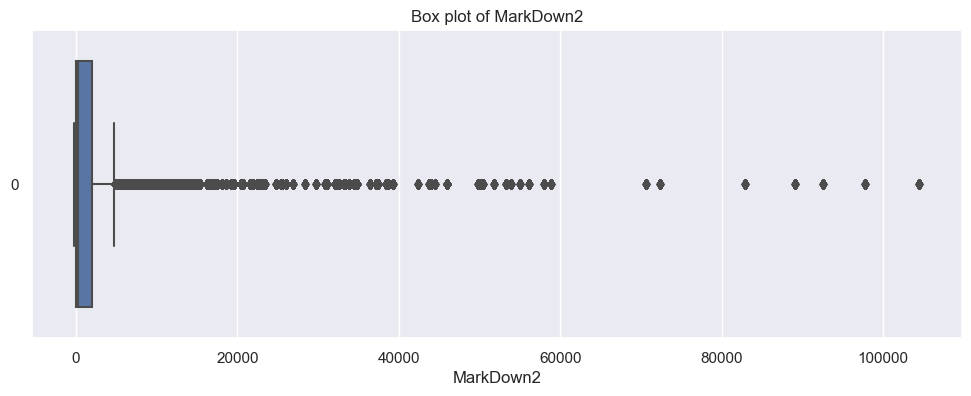

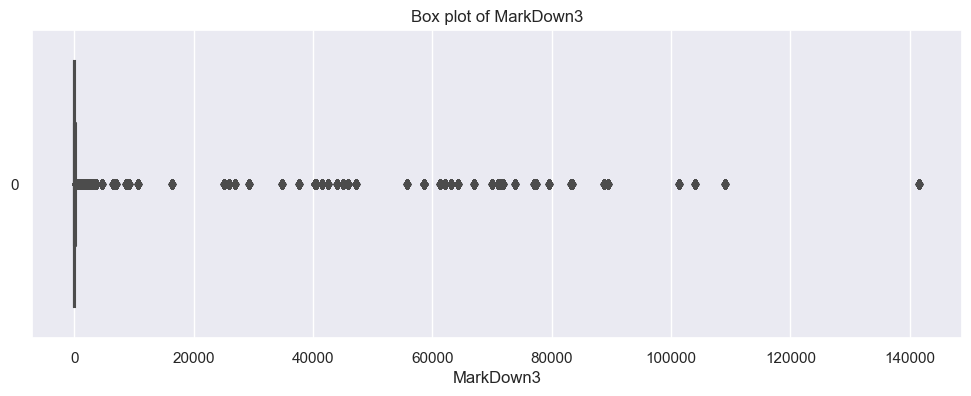

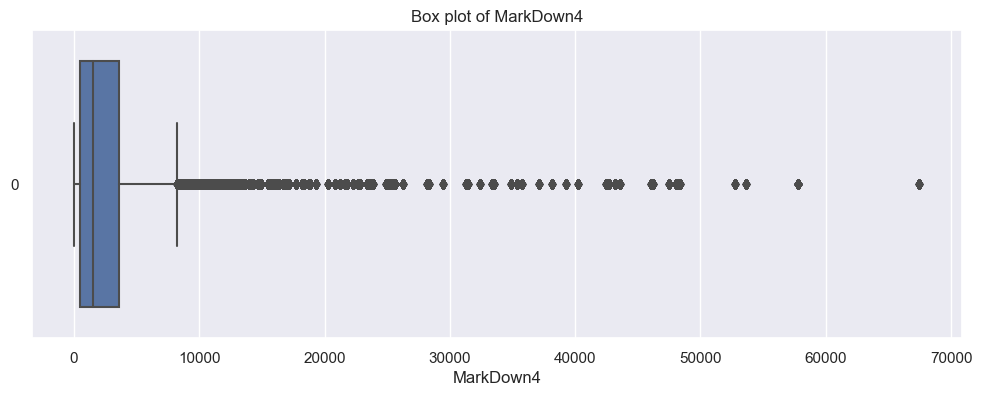

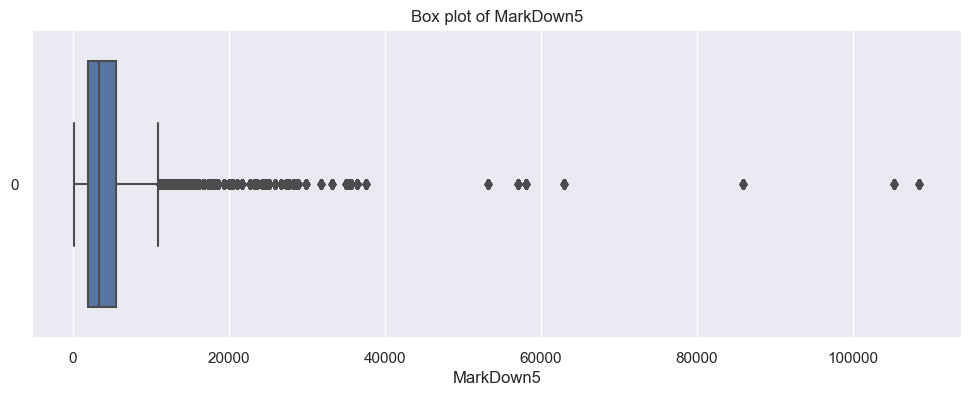

In [163]:
columns_to_plot = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4','MarkDown5']
plot_markdown_boxplots(df, columns_to_plot)

MarkDown'lara şimdilik dokunmuyorum. Silmek için çok fazla outlier var. 
Değişken hakkında çok detay bilmediğim için de çok doğru yorumlayamıyorum. 
O yüzden eğitim için outlier verilerden çok etkilenmeyen ağaç temelli yöntemleri kullanabiliriz. 

### MISSING VALUE ANALİZİ

In [141]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")

    if na_name:
        return na_columns

In [142]:
missing_values_table(df, True)

           n_miss  ratio
MarkDown2  310322 73.610
MarkDown4  286603 67.980
MarkDown3  284479 67.480
MarkDown1  270889 64.260
MarkDown5  270138 64.080


['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']

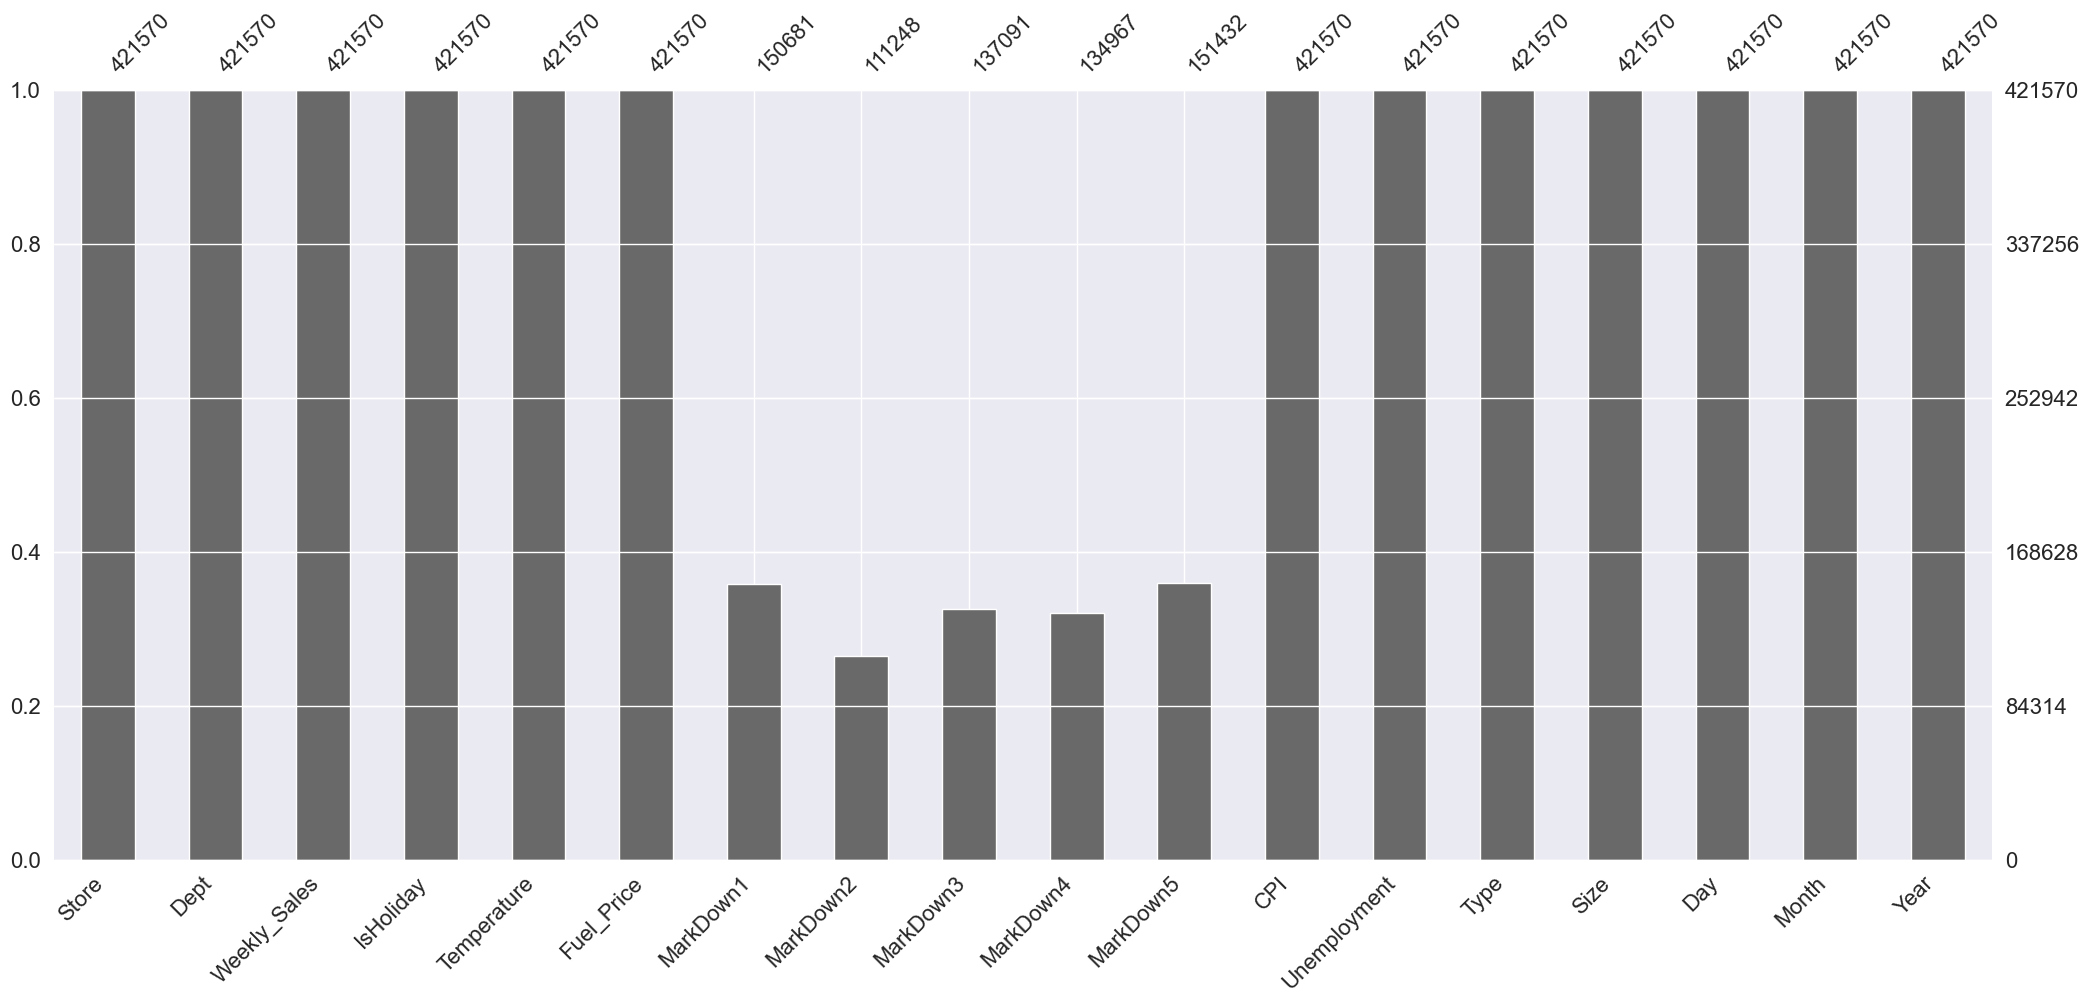

In [143]:
#eksik verileri msno kütüphanesi ile aşağıdaki gibi görselleştirerek yorumlayabiliriz.
msno.bar(df)
plt.show()

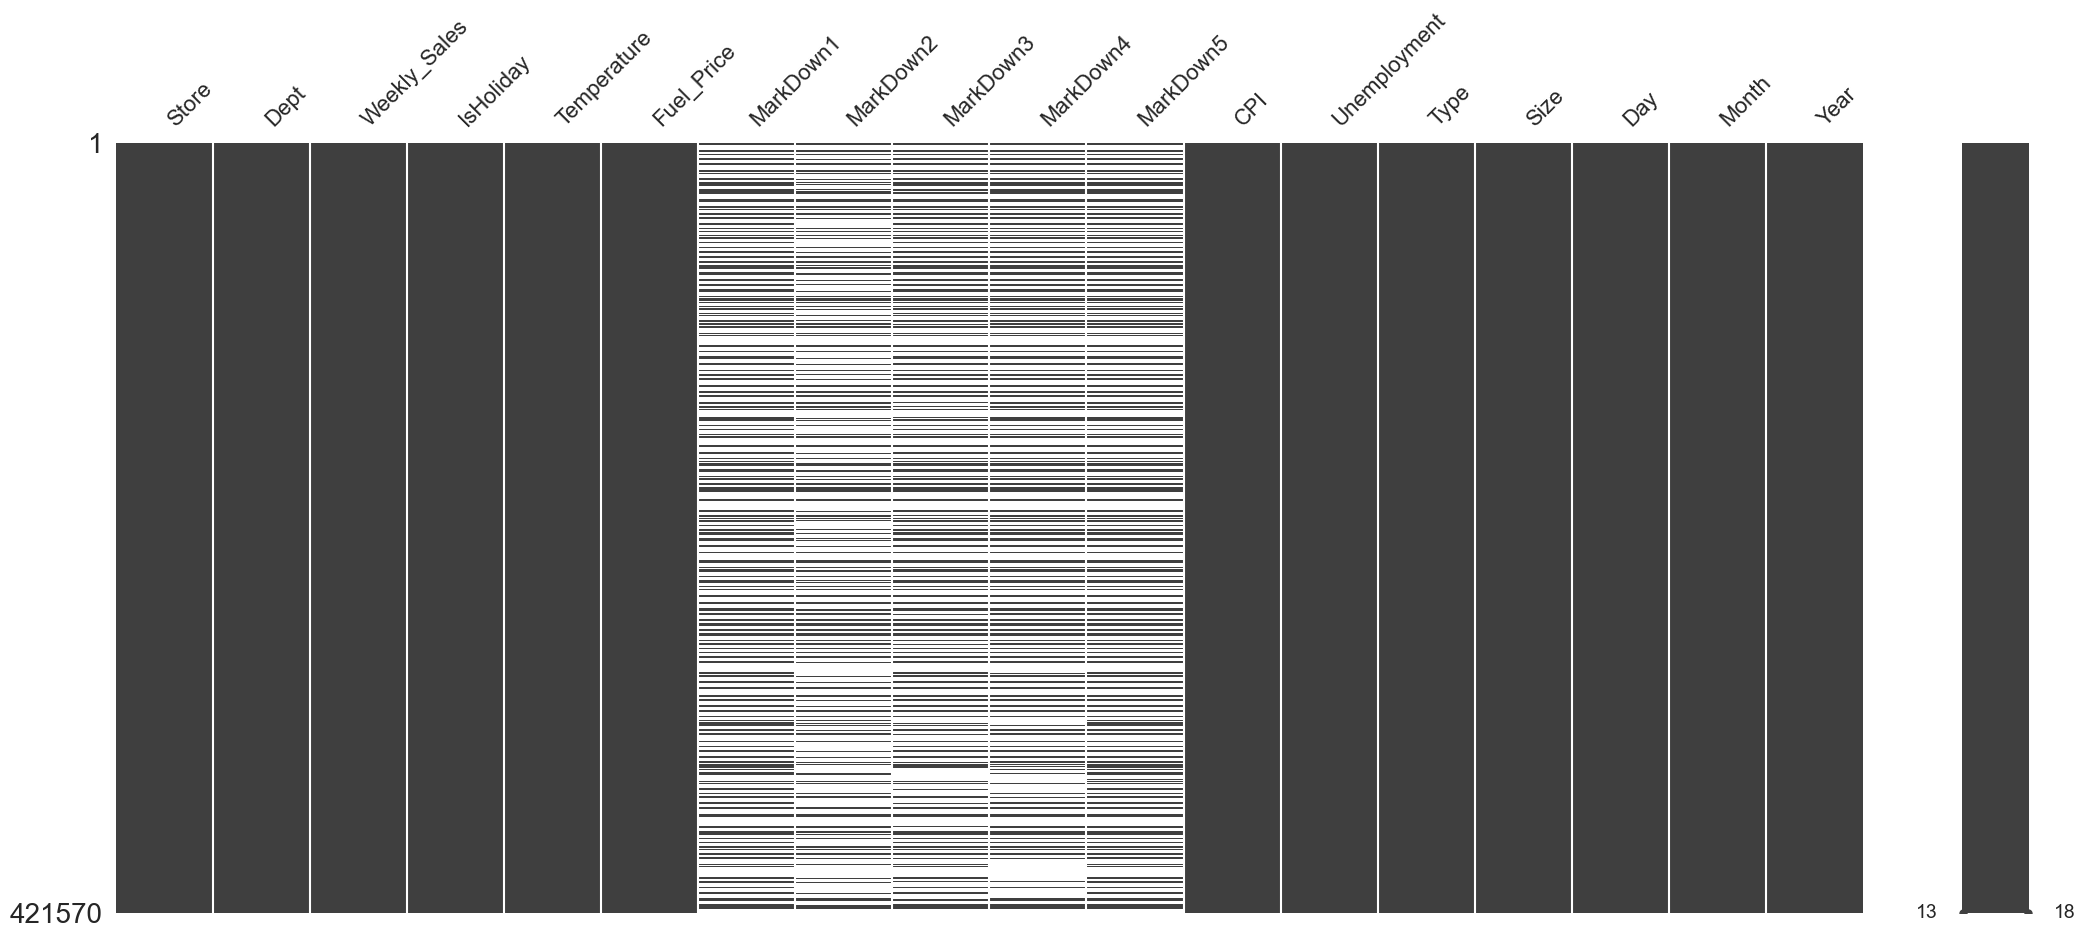

In [144]:
msno.matrix(df)
plt.show()

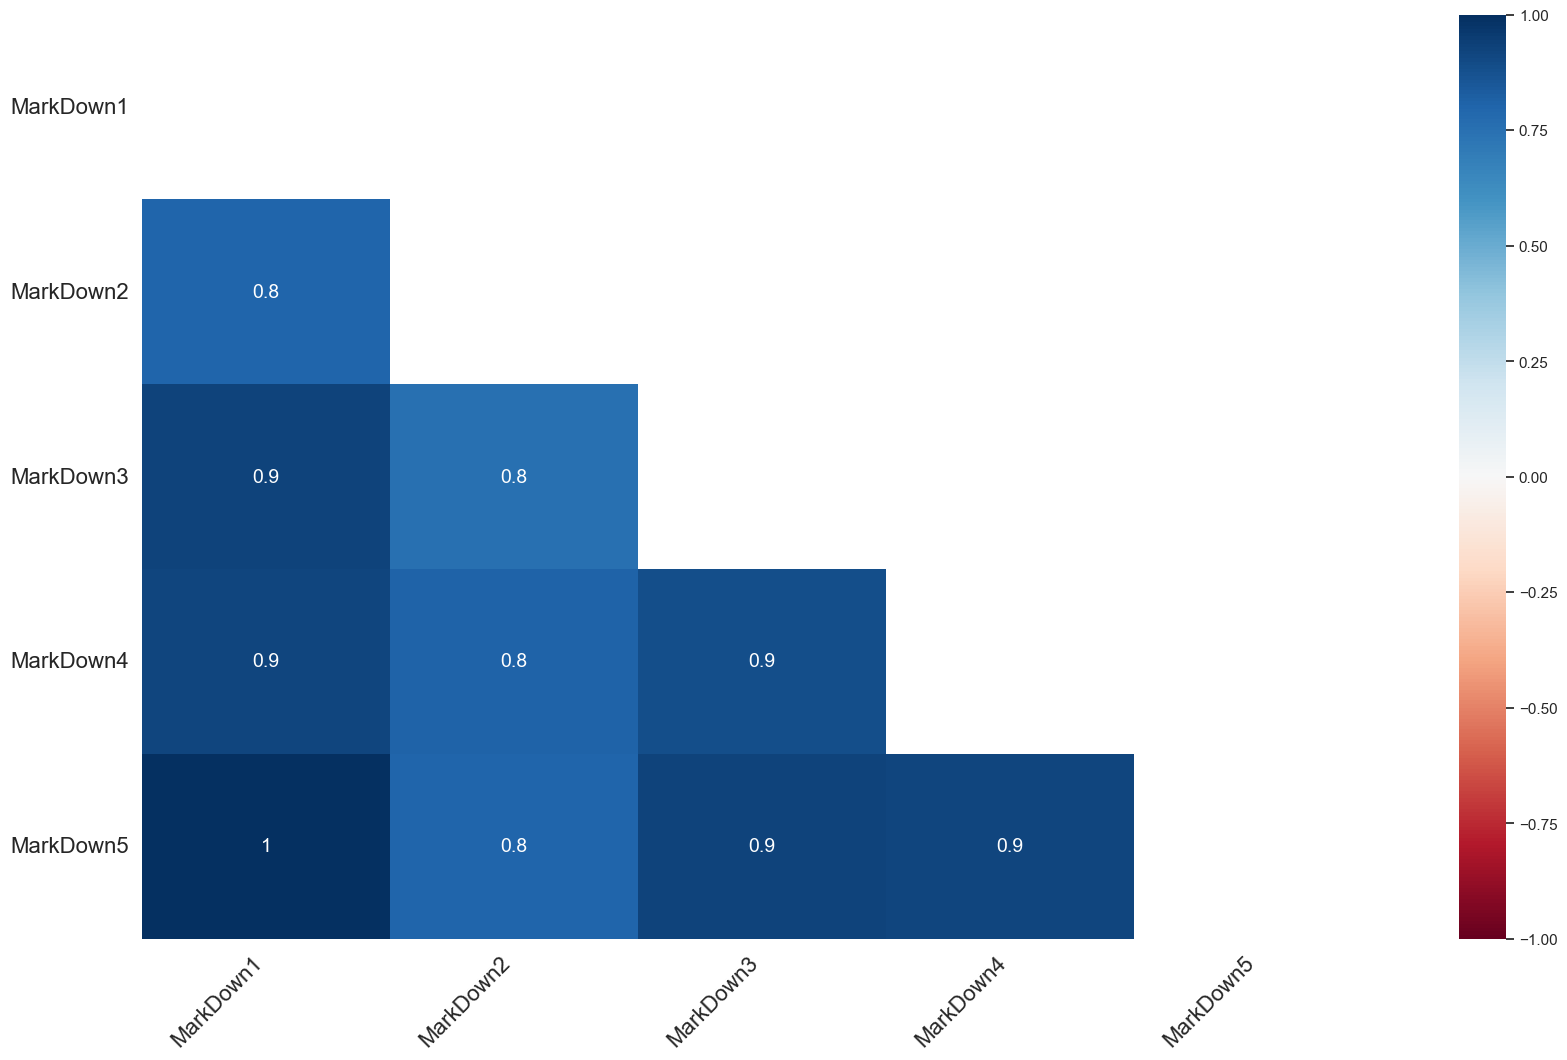

In [145]:
msno.heatmap(df) #değişkenlerin eksikliği arasında artı veya eksi yönde korelasyon var mı
plt.show()

Değişkenlerdeki eksik değerlerde çok yüksek korelasyon var. Yani veride rastgele değil yapısal bir eksiklik mevcut.
Bu yüzden KnnImputer yöntemiyle doldurmaya karar verdim.

In [147]:
new_df_copy= new_df

In [149]:
# encode edelim
new_df = pd.get_dummies(new_df[cat_cols + num_cols], drop_first=True)
new_df.head()

IsHoliday  Store  Dept  Day  Month  Year  Weekly_Sales  Temperature  Fuel_Price  MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5     CPI  Unemployment    Size  Type_B  Type_C
Date                                                                                                                                                                                            
2010-02-05          0      1     1    5      2  2010     24924.500       42.310       2.572        NaN        NaN        NaN        NaN        NaN 211.096         8.106  151315   False   False
2010-02-12          1      1     1   12      2  2010     46039.490       38.510       2.548        NaN        NaN        NaN        NaN        NaN 211.242         8.106  151315   False   False
2010-02-19          0      1     1   19      2  2010     41595.550       39.930       2.514        NaN        NaN        NaN        NaN        NaN 211.289         8.106  151315   False   False
2010-02-26          0      1     1   26      2  2010     19403.540       46.630       2.561        NaN        NaN        NaN        NaN        NaN 211.320         8.106  151315   False   False
2010-03-05          0      1     1    5      3  2010     21827.900       46.500       2.625        NaN        NaN        NaN        NaN        NaN 211.350         8.106  151315   False   False

In [150]:
# değişkenlerin standartlatırılması
scaler = MinMaxScaler()
new_df = pd.DataFrame(scaler.fit_transform(new_df), columns=new_df.columns)
new_df.head()

IsHoliday  Store  Dept   Day  Month  Year  Weekly_Sales  Temperature  Fuel_Price  MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5   CPI  Unemployment  Size  Type_B  Type_C
0      0.000  0.000 0.000 0.133  0.091 0.000         0.125        0.434       0.050        NaN        NaN        NaN        NaN        NaN 0.840         0.405 0.630   0.000   0.000
1      1.000  0.000 0.000 0.367  0.091 0.000         0.231        0.397       0.038        NaN        NaN        NaN        NaN        NaN 0.842         0.405 0.630   0.000   0.000
2      0.000  0.000 0.000 0.600  0.091 0.000         0.208        0.411       0.021        NaN        NaN        NaN        NaN        NaN 0.842         0.405 0.630   0.000   0.000
3      0.000  0.000 0.000 0.833  0.091 0.000         0.097        0.476       0.045        NaN        NaN        NaN        NaN        NaN 0.843         0.405 0.630   0.000   0.000
4      0.000  0.000 0.000 0.133  0.182 0.000         0.109        0.475       0.077        NaN        NaN        NaN        NaN        NaN 0.843         0.405 0.630   0.000   0.000

In [151]:
# knn'in uygulanması.
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
new_df = pd.DataFrame(imputer.fit_transform(new_df), columns=new_df.columns)
new_df.head()

IsHoliday  Store  Dept   Day  Month  Year  Weekly_Sales  Temperature  Fuel_Price  MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5   CPI  Unemployment  Size  Type_B  Type_C
0      0.000  0.000 0.000 0.133  0.091 0.000         0.125        0.434       0.050      0.071      0.211      0.001      0.021      0.077 0.840         0.405 0.630   0.000   0.000
1      1.000  0.000 0.000 0.367  0.091 0.000         0.231        0.397       0.038      0.157      0.069      0.001      0.126      0.062 0.842         0.405 0.630   0.000   0.000
2      0.000  0.000 0.000 0.600  0.091 0.000         0.208        0.411       0.021      0.069      0.005      0.001      0.006      0.054 0.842         0.405 0.630   0.000   0.000
3      0.000  0.000 0.000 0.833  0.091 0.000         0.097        0.476       0.045      0.046      0.008      0.001      0.004      0.036 0.843         0.405 0.630   0.000   0.000
4      0.000  0.000 0.000 0.133  0.182 0.000         0.109        0.475       0.077      0.117      0.061      0.002      0.036      0.059 0.843         0.405 0.630   0.000   0.000

In [152]:
new_df = pd.DataFrame(scaler.inverse_transform(new_df), columns=new_df.columns)
new_df.head()

IsHoliday  Store  Dept    Day  Month     Year  Weekly_Sales  Temperature  Fuel_Price  MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5     CPI  Unemployment       Size  Type_B  Type_C
0      0.000  1.000 1.000  5.000  2.000 2010.000     24924.500       42.310       2.572   6277.390  21813.160    143.100   1450.130   8483.000 211.096         8.106 151315.000   0.000   0.000
1      1.000  1.000 1.000 12.000  2.000 2010.000     46039.490       38.510       2.548  13925.060   6927.230    101.640   8471.880   6886.040 211.242         8.106 151315.000   0.000   0.000
2      0.000  1.000 1.000 19.000  2.000 2010.000     41595.550       39.930       2.514   6074.120    254.390     51.980    427.390   5988.570 211.289         8.106 151315.000   0.000   0.000
3      0.000  1.000 1.000 26.000  2.000 2010.000     19403.540       46.630       2.561   4110.256    585.730     48.788    260.834   4082.018 211.320         8.106 151315.000   0.000   0.000
4      0.000  1.000 1.000  5.000  3.000 2010.000     21827.900       46.500       2.625  10382.900   6115.670    215.070   2406.620   6551.420 211.350         8.106 151315.000   0.000   0.000

In [155]:
new_df.isnull().any()

IsHoliday       False
Store           False
Dept            False
Day             False
Month           False
Year            False
Weekly_Sales    False
Temperature     False
Fuel_Price      False
MarkDown1       False
MarkDown2       False
MarkDown3       False
MarkDown4       False
MarkDown5       False
CPI             False
Unemployment    False
Size            False
Type_B          False
Type_C          False
dtype: bool

Eski haliyle yeni halini karşılaştıralım.

In [156]:
df.describe([0.05, 0.5, 0.25, 0.95, 0.99,]).T

count       mean       std       min        5%       25%        50%        95%        99%        max
Store        421570.000     22.201    12.785     1.000     3.000    11.000     22.000     43.000     45.000     45.000
Dept         421570.000     44.260    30.492     1.000     4.000    18.000     37.000     95.000     98.000     99.000
Weekly_Sales 421570.000  15981.258 22711.184 -4988.940    59.975  2079.650   7612.030  61201.951 106479.586 693099.360
IsHoliday    421570.000      0.070     0.256     0.000     0.000     0.000      0.000      1.000      1.000      1.000
Temperature  421570.000     60.090    18.448    -2.060    27.310    46.680     62.090     87.270     92.810    100.140
Fuel_Price   421570.000      3.361     0.459     2.472     2.653     2.933      3.452      4.029      4.202      4.468
MarkDown1    150681.000   7246.420  8291.221     0.270   149.190  2240.270   5347.450  21801.350  41524.030  88646.760
MarkDown2    111248.000   3334.629  9475.357  -265.760     1.950    41.600    192.000  16497.470  50366.600 104519.540
MarkDown3    137091.000   1439.421  9623.078   -29.100     0.650     5.080     24.600   1059.900  63143.290 141630.610
MarkDown4    134967.000   3383.168  6292.384     0.220    28.760   504.220   1481.310  12645.960  35785.260  67474.850
MarkDown5    151432.000   4628.975  5962.887   135.160   715.520  1878.440   3359.450  11269.240  27754.230 108519.280
CPI          421570.000    171.202    39.159   126.064   126.496   132.023    182.319    221.942    225.474    227.233
Unemployment 421570.000      7.960     1.863     3.879     5.326     6.891      7.866     12.187     14.180     14.313
Size         421570.000 136727.916 60980.583 34875.000 39690.000 93638.000 140167.000 206302.000 219622.000 219622.000
Day          421570.000     15.673     8.754     1.000     2.000     8.000     16.000     29.000     31.000     31.000
Month        421570.000      6.450     3.243     1.000     1.000     4.000      6.000     12.000     12.000     12.000
Year         421570.000   2010.969     0.797  2010.000  2010.000  2010.000   2011.000   2012.000   2012.000   2012.000

In [157]:
new_df.describe([0.05, 0.5, 0.25, 0.95, 0.99,]).T

count       mean       std       min        5%       25%        50%        95%        99%        max
IsHoliday    420122.000      0.070     0.256     0.000     0.000     0.000      0.000      1.000      1.000      1.000
Store        420122.000     22.198    12.788     1.000     3.000    11.000     22.000     43.000     45.000     45.000
Dept         420122.000     44.235    30.504     1.000     4.000    18.000     37.000     95.000     98.000     99.000
Day          420122.000     15.672     8.753     1.000     2.000     8.000     16.000     29.000     31.000     31.000
Month        420122.000      6.448     3.243     1.000     1.000     4.000      6.000     12.000     12.000     12.000
Year         420122.000   2010.969     0.797  2010.000  2010.000  2010.000   2011.000   2012.000   2012.000   2012.000
Weekly_Sales 420122.000  15933.896 22135.675     0.000    66.881  2116.168   7652.855  61110.978 105438.147 199674.330
Temperature  420122.000     60.096    18.448    -2.060    27.310    46.700     62.100     87.270     92.810    100.140
Fuel_Price   420122.000      3.361     0.459     2.472     2.653     2.933      3.452      4.029      4.202      4.468
MarkDown1    420122.000   7187.931  7959.347     0.270    65.320  2114.640   5251.980  22865.190  37194.440  88646.760
MarkDown2    420122.000   3438.375  8511.657  -265.760     2.630    50.470    317.080  16658.470  44021.610 104519.540
MarkDown3    420122.000   1445.676  8858.949   -29.100     1.064     8.130     65.950   1902.550  55805.510 141630.610
MarkDown4    420122.000   2691.243  5637.343     0.220     8.000   295.130    955.480  10055.750  33529.140  67474.850
MarkDown5    420122.000   5442.785  5792.184   135.160   796.280  2209.210   4078.210  15323.920  28803.280 108519.280
CPI          420122.000    171.213    39.164   126.064   126.496   132.023    182.351    221.942    225.474    227.233
Unemployment 420122.000      7.960     1.864     3.879     5.326     6.891      7.866     12.187     14.180     14.313
Size         420122.000 136732.727 60993.762 34875.000 39690.000 93638.000 140167.000 206302.000 219622.000 219622.000
Type_B       420122.000      0.387     0.487     0.000     0.000     0.000      0.000      1.000      1.000      1.000
Type_C       420122.000      0.101     0.301     0.000     0.000     0.000      0.000      1.000      1.000      1.000

ortalamada, min, max, std değerde çok büyük oynama yok. veriyi bozmadık diyebiliriz.

In [171]:
new_df.to_csv('walmart_final.csv', index=False)